# Lab 5: Non-negative Matrix Factorization

The goal of this lab session is to code a NMF algorithm and use it in some applications.

We begin with the standard imports:

In [1]:
import numpy             as np
import matplotlib.pyplot as plt
import seaborn           as sns
from sklearn.utils       import check_random_state
from sklearn.datasets    import fetch_olivetti_faces

%matplotlib inline
sns.set_context('poster')
sns.set_color_codes()
plot_kwds        = {'alpha' : 0.25, 's' : 80, 'linewidths':0}

dataset          = fetch_olivetti_faces(shuffle=True)
faces            = dataset.data.T #on représente chaque image par une colonne, en accord avec le cours
faces[3523][338] = 1e-2 #l'un des éléments de faces est nul, ce qui bloque la divergence de KL
from tqdm import tqdm

## NMF

Loss (Regularized Froebnius): $\mathcal{L}(D, S) = \frac{1}{2}\|X-D S\|_{F}^{2}+ \color{red}{\frac{\mu}{2}\|S\|_{F}^{2}+\lambda\|S\|_{1}+\frac{\nu}{2}\|D\|_{F}^{2}}$

Algorithm (multiplicative updates from [Lee and Seung, 1999]: 

\begin{array}{c}
D \leftarrow D \circ \frac{X S^{\top}}{D (S S^{\top} + {\color{red} \nu I_r})} \\
S \leftarrow S \circ \frac{D^{\top} X - {\color{red} \lambda 1_{r \times n}}}{(D^{\top} D + {\color{red} \mu I_r})S}
\end{array}

Fill in the following NMF class:

In [2]:
class MYNMF():
    
    """ Class for logistic regression:
    
    Attributes:                                                                                 
    -----------                                                Default value
    n_components_ : integer,  unknown dimension of W and H   | 300                
    max_iter_     : integer,  maximum number of iterations   | 60
    epsilon_      : float,    epsilon coefficient            | 1e-4
    loss_         : str,      {"Frobenius", "KL"}            | Frobenius
    D_            : np.array, W Matrix factor                | None
    S_            : np.array, H Matrix factor                | None
    D_history     : list,     W Matrix history               | []
    S_history     : list,     H Matrix history               | []
    loss_history  : list,     history of loss                | []
    random_state  : int,      for the random initialization  | 42
    """
    
    def __init__(self, n_components=20, max_iter=200, epsilon = 1e-5, loss = "Frobenius", random_state=42):
        
        self.n_components_ = n_components
        self.max_iter_     = max_iter
        self.epsilon_      = epsilon
        self.loss_         = loss
        self.D_            = None
        self.S_            = None
        self.D_history     = []
        self.S_history     = []
        self.loss_history  = []
        self.random_state  = random_state
        self.components_   = None    # shape (r, p)
        
    def fit_transform(self, data, mu=5e-3,  nu=5e-3, lambd=1e-3):
        
        """ Find the factor matrices D and S for matrix factorization of data
        
        Parameters:
        -----------                                 Default value       
        data  : (p, n) np.arrayData, matrix       | 
        mu    : float, regularization parameter   | 5e-3
        lambd : float, regularization parameter   | 1e-3
        nu    : float, regularization parameter   | 5e-3
        
        Returns:
        -----
        embedding: (p, r) np.array
                    Embedding matrix        
        """    
        # set the seed for reproductivity
        np.random.seed(self.random_state)    
        
        self.D_ = np.random.random(size = (data.shape[0], self.n_components_))
        self.S_ = np.random.random(size = (self.n_components_, data.shape[1]))
        
        def compute_loss(data):
            """
            Compute the loss function
            """
            new_space = self.D_@self.S_
            if self.loss_ == 'Frobenius':
                return np.linalg.norm(data - new_space,ord = 'fro') + 0.5*mu*np.linalg.norm(self.S_, "fro")**2 + lambd*np.linalg.norm(self.S_, 1) + 0.5*nu*np.linalg.norm(self.D_, "fro")**2
            else:
                #  problem with log when data = 0 or new_space = 0
                return np.sum(np.where((data != 0) & (new_space !=0) , data*np.log(data/new_space) - data + new_space, 0))
            
        # updating histories 
        self.D_history.append(self.D_)
        self.S_history.append(self.S_)
        self.loss_history.append(compute_loss(data))

        if self.loss_ == 'Frobenius':
            for iter in tqdm(range(self.max_iter_)):
                #D = D*((X@S.T)/(D@(S@S.T + nu*np.identity(self.n_components_))))
                # S = S*((D.T@X - lambd*np.ones((self.n_components_, data.shape[0])))/((D.T@D + mu*np.identity(self.n_components_))@S))

                self.D_ = self.D_*((data@(self.S_.T))/(self.D_@(self.S_@(self.S_.T) + nu*np.identity(self.n_components_))))
                self.S_ = self.S_* ((self.D_.T@data - lambd)/((self.D_.T@self.D_ + mu*np.identity(self.n_components_))@self.S_))
                self.D_history.append(self.D_)
                self.S_history.append(self.S_)
                self.loss_history.append(compute_loss(data))
        else:
            for iter in tqdm(range(self.max_iter_)):
                # we can re-write the relations given in the course as a marix format :\
                # W = W*(X/(W@H)@H.T)/sum(H, axis = 1) 
                # D = D*(((X/(D@S))@S.T)/np.sum(S, axis=1)[:,None].T)
                # S = S*(((D.T)@(X/(D@S)))/np.sum(D, axis=0)[None,:].T)

                self.D_ = self.D_ * (((data/ (self.D_@self.S_))@self.S_.T) / np.sum(self.S_, axis = 1)[None,:])
                self.S_ = self.S_ * ((self.D_.T @ (data/(self.D_@self.S_))) / np.sum(self.D_, axis = 0)[:, None])
                self.D_history.append(self.D_)
                self.S_history.append(self.S_)
                self.loss_history.append(compute_loss(data))
        # here we supposed the individuals are concatenated in columns but for predictions and representations we will consider that they \
        # are represented in rows that's why is it a good practice to return the transpose matrix for S and D -----> not exactly true 
        self.components_ = self.D_
        return self.S_

    def predict_label(self, X):
        """ Predict labels for X : cluster hard-assignment
        
        Parameters:
        -----------
        X: (n, p) np.array, data matrix
        
        Returns:
        -----
        label assignment : (p, ) np.array, Its elements are the predicted classes, from 0 to r-1
        """
        # we're looking for the embedding giving the components and the matrix X, we'll use the pseudo inverse because we have no guarantee that the componenets matrix in inversible
        return np.argmax(X@np.linalg.pinv(self.components_), axis = 1)
        
    def predict_proba(self, X):
        """ Predict probabilities of different classes for X :  cluster soft-assignment
        
        Parameters:
        -----------
        X: (n, p) np.array
            New data matrix
        
        Returns:
        -----
        label_assignment : (p, r) np.array
                          Its elements are the probabilities for different classes
        """
        embedding = X@np.linalg.pinv(self.components_)
        # we should normalize it to have probabilities for each row 
        return embedding/embedding.sum(axis = 1)[None,:]

## Hyperparameter optimization

### Regularization parameter : mu

In [3]:
#TODO : find best mu
# to do so we can use the elbow method 
mus = np.linspace(0.001,1, 50)

loss_frob = []

for mu_ in tqdm(mus):
    print(f'testing mu = {mu_} :')
    model = MYNMF(n_components=40, loss= 'Frobenius')
    toto = model.fit_transform(faces, mu = mu_)
    loss_frob.append(model.loss_history[-1])

  0%|          | 0/50 [00:00<?, ?it/s]

testing mu = 0.001 :


  2%|▏         | 1/50 [00:13<11:18, 13.85s/it]

testing mu = 0.021387755102040818 :


  4%|▍         | 2/50 [00:26<10:30, 13.14s/it]

testing mu = 0.041775510204081635 :


  6%|▌         | 3/50 [00:39<10:13, 13.06s/it]

testing mu = 0.062163265306122456 :


  8%|▊         | 4/50 [00:53<10:12, 13.32s/it]

testing mu = 0.08255102040816327 :


 10%|█         | 5/50 [01:06<10:04, 13.43s/it]

testing mu = 0.10293877551020408 :


 12%|█▏        | 6/50 [01:28<11:51, 16.16s/it]

testing mu = 0.12332653061224491 :


 14%|█▍        | 7/50 [01:45<11:44, 16.39s/it]

testing mu = 0.1437142857142857 :


 16%|█▌        | 8/50 [01:56<10:19, 14.75s/it]

testing mu = 0.16410204081632654 :


 18%|█▊        | 9/50 [02:07<09:16, 13.57s/it]

testing mu = 0.18448979591836737 :


 20%|██        | 10/50 [02:18<08:27, 12.68s/it]

testing mu = 0.20487755102040817 :


 22%|██▏       | 11/50 [02:28<07:53, 12.15s/it]

testing mu = 0.225265306122449 :


 24%|██▍       | 12/50 [02:39<07:22, 11.65s/it]

testing mu = 0.24565306122448982 :


 26%|██▌       | 13/50 [02:50<07:02, 11.41s/it]

testing mu = 0.26604081632653065 :


 28%|██▊       | 14/50 [03:01<06:46, 11.28s/it]

testing mu = 0.2864285714285714 :


 30%|███       | 15/50 [03:12<06:34, 11.28s/it]

testing mu = 0.30681632653061225 :


 32%|███▏      | 16/50 [03:23<06:21, 11.22s/it]

testing mu = 0.3272040816326531 :


 34%|███▍      | 17/50 [03:34<06:10, 11.23s/it]

testing mu = 0.3475918367346939 :


 36%|███▌      | 18/50 [03:45<05:56, 11.15s/it]

testing mu = 0.36797959183673473 :


 38%|███▊      | 19/50 [03:56<05:41, 11.01s/it]

testing mu = 0.3883673469387755 :


 40%|████      | 20/50 [04:06<05:24, 10.82s/it]

testing mu = 0.40875510204081633 :


 42%|████▏     | 21/50 [04:17<05:11, 10.74s/it]

testing mu = 0.42914285714285716 :


 44%|████▍     | 22/50 [04:28<04:58, 10.67s/it]

testing mu = 0.449530612244898 :


 46%|████▌     | 23/50 [04:38<04:45, 10.56s/it]

testing mu = 0.4699183673469388 :


 48%|████▊     | 24/50 [04:48<04:34, 10.56s/it]

testing mu = 0.49030612244897964 :


 50%|█████     | 25/50 [04:59<04:22, 10.51s/it]

testing mu = 0.5106938775510205 :


 52%|█████▏    | 26/50 [05:09<04:11, 10.46s/it]

testing mu = 0.5310816326530613 :


 54%|█████▍    | 27/50 [05:20<04:01, 10.49s/it]

testing mu = 0.551469387755102 :


 56%|█████▌    | 28/50 [05:30<03:51, 10.54s/it]

testing mu = 0.5718571428571428 :


 58%|█████▊    | 29/50 [05:41<03:42, 10.61s/it]

testing mu = 0.5922448979591837 :


 60%|██████    | 30/50 [05:52<03:32, 10.63s/it]

testing mu = 0.6126326530612245 :


 62%|██████▏   | 31/50 [06:02<03:21, 10.63s/it]

testing mu = 0.6330204081632653 :


 64%|██████▍   | 32/50 [06:13<03:10, 10.57s/it]

testing mu = 0.6534081632653062 :


 66%|██████▌   | 33/50 [06:23<02:59, 10.54s/it]

testing mu = 0.673795918367347 :


 68%|██████▊   | 34/50 [06:35<02:51, 10.73s/it]

testing mu = 0.6941836734693878 :


 70%|███████   | 35/50 [06:45<02:39, 10.62s/it]

testing mu = 0.7145714285714286 :


 72%|███████▏  | 36/50 [06:56<02:29, 10.68s/it]

testing mu = 0.7349591836734695 :


 74%|███████▍  | 37/50 [07:06<02:17, 10.57s/it]

testing mu = 0.7553469387755103 :


 76%|███████▌  | 38/50 [07:19<02:16, 11.39s/it]

testing mu = 0.775734693877551 :


 78%|███████▊  | 39/50 [07:30<02:02, 11.16s/it]

testing mu = 0.7961224489795918 :


 80%|████████  | 40/50 [07:43<01:56, 11.66s/it]

testing mu = 0.8165102040816327 :


 82%|████████▏ | 41/50 [07:54<01:43, 11.45s/it]

testing mu = 0.8368979591836735 :


 84%|████████▍ | 42/50 [08:04<01:29, 11.21s/it]

testing mu = 0.8572857142857143 :


 86%|████████▌ | 43/50 [08:17<01:21, 11.57s/it]

testing mu = 0.8776734693877551 :


 88%|████████▊ | 44/50 [08:29<01:10, 11.76s/it]

testing mu = 0.898061224489796 :


 90%|█████████ | 45/50 [08:40<00:58, 11.64s/it]

testing mu = 0.9184489795918368 :


 92%|█████████▏| 46/50 [08:53<00:47, 11.87s/it]

testing mu = 0.9388367346938776 :


 94%|█████████▍| 47/50 [09:05<00:35, 11.92s/it]

testing mu = 0.9592244897959185 :


 96%|█████████▌| 48/50 [09:18<00:24, 12.22s/it]

testing mu = 0.9796122448979593 :


 98%|█████████▊| 49/50 [09:30<00:12, 12.10s/it]

testing mu = 1.0 :


100%|██████████| 50/50 [09:44<00:00, 11.68s/it]


In [5]:
# Now we need to plot the graph and see localize the knee, to do so we're going to use a package called KneeLocator from kneed
try:
    from kneed import KneeLocator
except:
    !pip install kneed
    from kneed import KneeLocator

kn = KneeLocator(mus, loss_frob, curve='convex', direction='decreasing')
knee = kn.knee
print(f'best value found is: {knee}')
# importing plotly
import plotly.express as px
fig = px.line(x = mus,y =  loss_frob, title= 'evolution of loss w.r.t mu', labels={'x': 'mu', 'y':'final loss'})
fig.add_vline(x = knee)
fig.show()

best value found is: 0.001


** Conclusion:** Since the loss function is increasing with the parameter $\mu$, which is logical because as we give more importance to regularization term our predictions on the seen data will drop. Neverthless, we can use the elbow method., in our case we have $\mu = 0.04$

### Regularization parameter : nu

In [16]:
#TODO : find best nu
# the same thing with nu
nus = np.linspace(0.001,1, 50)

loss_frob = []

for nu_ in tqdm(nus):
    print(f'testing nu = {nu_} :')
    model = MYNMF(n_components=40, loss= 'Frobenius')
    toto = model.fit_transform(faces, nu = nu_, mu = 0.04)
    loss_frob.append(model.loss_history[-1])

  0%|          | 0/50 [00:00<?, ?it/s]

testing nu = 0.001 :


  2%|▏         | 1/50 [00:17<14:13, 17.43s/it]

testing nu = 0.021387755102040818 :


  4%|▍         | 2/50 [00:28<11:00, 13.76s/it]

testing nu = 0.041775510204081635 :


  6%|▌         | 3/50 [00:39<09:49, 12.55s/it]

testing nu = 0.062163265306122456 :


  8%|▊         | 4/50 [00:54<10:17, 13.42s/it]

testing nu = 0.08255102040816327 :


 10%|█         | 5/50 [01:10<10:43, 14.29s/it]

testing nu = 0.10293877551020408 :


 12%|█▏        | 6/50 [01:24<10:29, 14.31s/it]

testing nu = 0.12332653061224491 :


 14%|█▍        | 7/50 [01:38<10:10, 14.20s/it]

testing nu = 0.1437142857142857 :


 16%|█▌        | 8/50 [01:54<10:19, 14.75s/it]

testing nu = 0.16410204081632654 :


 18%|█▊        | 9/50 [02:13<10:56, 16.01s/it]

testing nu = 0.18448979591836737 :


 20%|██        | 10/50 [02:28<10:31, 15.78s/it]

testing nu = 0.20487755102040817 :


 22%|██▏       | 11/50 [02:42<09:51, 15.17s/it]

testing nu = 0.225265306122449 :


 24%|██▍       | 12/50 [02:57<09:36, 15.16s/it]

testing nu = 0.24565306122448982 :


 26%|██▌       | 13/50 [03:11<09:03, 14.70s/it]

testing nu = 0.26604081632653065 :


 28%|██▊       | 14/50 [03:25<08:44, 14.56s/it]

testing nu = 0.2864285714285714 :


 30%|███       | 15/50 [03:40<08:34, 14.71s/it]

testing nu = 0.30681632653061225 :


 32%|███▏      | 16/50 [03:53<08:03, 14.21s/it]

testing nu = 0.3272040816326531 :


 34%|███▍      | 17/50 [04:05<07:23, 13.44s/it]

testing nu = 0.3475918367346939 :


 36%|███▌      | 18/50 [04:17<06:54, 12.97s/it]

testing nu = 0.36797959183673473 :


 38%|███▊      | 19/50 [04:31<06:52, 13.31s/it]

testing nu = 0.3883673469387755 :


 40%|████      | 20/50 [04:46<06:55, 13.83s/it]

testing nu = 0.40875510204081633 :


 42%|████▏     | 21/50 [04:57<06:22, 13.18s/it]

testing nu = 0.42914285714285716 :


 44%|████▍     | 22/50 [05:09<05:56, 12.72s/it]

testing nu = 0.449530612244898 :


 46%|████▌     | 23/50 [05:23<05:57, 13.23s/it]

testing nu = 0.4699183673469388 :


 48%|████▊     | 24/50 [05:37<05:46, 13.34s/it]

testing nu = 0.49030612244897964 :


 50%|█████     | 25/50 [05:49<05:20, 12.82s/it]

testing nu = 0.5106938775510205 :


 52%|█████▏    | 26/50 [06:00<04:59, 12.47s/it]

testing nu = 0.5310816326530613 :


 54%|█████▍    | 27/50 [06:12<04:42, 12.26s/it]

testing nu = 0.551469387755102 :


 56%|█████▌    | 28/50 [06:23<04:24, 12.02s/it]

testing nu = 0.5718571428571428 :


 58%|█████▊    | 29/50 [06:36<04:16, 12.20s/it]

testing nu = 0.5922448979591837 :


 60%|██████    | 30/50 [06:48<04:01, 12.06s/it]

testing nu = 0.6126326530612245 :


 62%|██████▏   | 31/50 [07:01<03:53, 12.30s/it]

testing nu = 0.6330204081632653 :


 64%|██████▍   | 32/50 [07:14<03:47, 12.62s/it]

testing nu = 0.6534081632653062 :


 66%|██████▌   | 33/50 [07:28<03:41, 13.04s/it]

testing nu = 0.673795918367347 :


 68%|██████▊   | 34/50 [07:43<03:37, 13.61s/it]

testing nu = 0.6941836734693878 :


 70%|███████   | 35/50 [07:59<03:32, 14.19s/it]

testing nu = 0.7145714285714286 :


 72%|███████▏  | 36/50 [08:15<03:27, 14.85s/it]

testing nu = 0.7349591836734695 :


 74%|███████▍  | 37/50 [08:28<03:05, 14.26s/it]

testing nu = 0.7553469387755103 :


 76%|███████▌  | 38/50 [08:41<02:48, 14.02s/it]

testing nu = 0.775734693877551 :


 78%|███████▊  | 39/50 [08:57<02:38, 14.42s/it]

testing nu = 0.7961224489795918 :


 80%|████████  | 40/50 [09:12<02:26, 14.63s/it]

testing nu = 0.8165102040816327 :


 82%|████████▏ | 41/50 [09:24<02:04, 13.80s/it]

testing nu = 0.8368979591836735 :


 84%|████████▍ | 42/50 [09:36<01:46, 13.35s/it]

testing nu = 0.8572857142857143 :


 86%|████████▌ | 43/50 [09:54<01:42, 14.61s/it]

testing nu = 0.8776734693877551 :


 88%|████████▊ | 44/50 [10:11<01:32, 15.43s/it]

testing nu = 0.898061224489796 :


 90%|█████████ | 45/50 [10:27<01:17, 15.58s/it]

testing nu = 0.9184489795918368 :


 92%|█████████▏| 46/50 [10:41<01:00, 15.04s/it]

testing nu = 0.9388367346938776 :


 94%|█████████▍| 47/50 [10:51<00:40, 13.52s/it]

testing nu = 0.9592244897959185 :


 96%|█████████▌| 48/50 [11:01<00:25, 12.74s/it]

testing nu = 0.9796122448979593 :


 98%|█████████▊| 49/50 [11:14<00:12, 12.72s/it]

testing nu = 1.0 :


100%|██████████| 50/50 [11:29<00:00, 13.78s/it]


In [17]:
# Now we need to plot the graph and see localize the knee, to do so we're going to use a package called KneeLocator from kneed

kn = KneeLocator(nus, loss_frob, curve='convex', direction='decreasing')
knee = kn.knee
print(f'best value found is: {knee}')
# importing plotly
import plotly.express as px
fig = px.line(x = nus,y =  loss_frob, title= 'evolution of loss w.r.t nu', labels={'x': 'nu', 'y':'final loss'})
fig.add_vline(x = knee)
fig.show()

best value found is: 0.001


best $\nu = 0$

### Regularization parameter : lambda

In [18]:
#TODO : find best lambda
lambdas = np.linspace(0.001,1, 50)

loss_frob = []

for lambd_ in tqdm(lambdas):
    print(f'testing lambda = {lambd_} :')
    model = MYNMF(n_components=40, loss= 'Frobenius')
    toto = model.fit_transform(faces, nu = 0, mu = 0.04, lambd= lambd_)
    loss_frob.append(model.loss_history[-1])

  0%|          | 0/50 [00:00<?, ?it/s]

testing lambda = 0.001 :


  2%|▏         | 1/50 [00:11<09:29, 11.63s/it]

testing lambda = 0.021387755102040818 :


  4%|▍         | 2/50 [00:21<08:15, 10.33s/it]

testing lambda = 0.041775510204081635 :


  6%|▌         | 3/50 [00:30<07:45,  9.91s/it]

testing lambda = 0.062163265306122456 :


  8%|▊         | 4/50 [00:39<07:20,  9.57s/it]

testing lambda = 0.08255102040816327 :


 10%|█         | 5/50 [00:48<07:06,  9.49s/it]

testing lambda = 0.10293877551020408 :


 12%|█▏        | 6/50 [00:57<06:48,  9.29s/it]

testing lambda = 0.12332653061224491 :


 14%|█▍        | 7/50 [01:06<06:37,  9.25s/it]

testing lambda = 0.1437142857142857 :


 16%|█▌        | 8/50 [01:16<06:29,  9.28s/it]

testing lambda = 0.16410204081632654 :


 18%|█▊        | 9/50 [01:27<06:43,  9.84s/it]

testing lambda = 0.18448979591836737 :


 20%|██        | 10/50 [01:39<07:04, 10.62s/it]

testing lambda = 0.20487755102040817 :


 22%|██▏       | 11/50 [01:52<07:23, 11.37s/it]

testing lambda = 0.225265306122449 :


 24%|██▍       | 12/50 [02:05<07:28, 11.81s/it]

testing lambda = 0.24565306122448982 :


 26%|██▌       | 13/50 [02:18<07:28, 12.11s/it]

testing lambda = 0.26604081632653065 :


 28%|██▊       | 14/50 [02:29<07:10, 11.95s/it]

testing lambda = 0.2864285714285714 :


 30%|███       | 15/50 [02:41<06:56, 11.91s/it]

testing lambda = 0.30681632653061225 :


 32%|███▏      | 16/50 [02:53<06:39, 11.76s/it]

testing lambda = 0.3272040816326531 :


 34%|███▍      | 17/50 [03:04<06:25, 11.68s/it]

testing lambda = 0.3475918367346939 :


 36%|███▌      | 18/50 [03:15<06:09, 11.55s/it]

testing lambda = 0.36797959183673473 :


 38%|███▊      | 19/50 [03:27<05:55, 11.48s/it]

testing lambda = 0.3883673469387755 :


 40%|████      | 20/50 [03:39<05:50, 11.69s/it]

testing lambda = 0.40875510204081633 :


 42%|████▏     | 21/50 [03:52<05:55, 12.24s/it]

testing lambda = 0.42914285714285716 :


 44%|████▍     | 22/50 [04:05<05:42, 12.22s/it]

testing lambda = 0.449530612244898 :


 46%|████▌     | 23/50 [04:17<05:30, 12.25s/it]

testing lambda = 0.4699183673469388 :


 48%|████▊     | 24/50 [04:29<05:16, 12.18s/it]

testing lambda = 0.49030612244897964 :


 50%|█████     | 25/50 [04:41<05:02, 12.09s/it]

testing lambda = 0.5106938775510205 :


 52%|█████▏    | 26/50 [04:53<04:48, 12.02s/it]

testing lambda = 0.5310816326530613 :


 54%|█████▍    | 27/50 [05:05<04:36, 12.04s/it]

testing lambda = 0.551469387755102 :


 56%|█████▌    | 28/50 [05:16<04:22, 11.93s/it]

testing lambda = 0.5718571428571428 :


 58%|█████▊    | 29/50 [05:28<04:09, 11.89s/it]

testing lambda = 0.5922448979591837 :


 60%|██████    | 30/50 [05:40<03:57, 11.85s/it]

testing lambda = 0.6126326530612245 :


 62%|██████▏   | 31/50 [05:52<03:44, 11.80s/it]

testing lambda = 0.6330204081632653 :


 64%|██████▍   | 32/50 [06:04<03:33, 11.85s/it]

testing lambda = 0.6534081632653062 :


 66%|██████▌   | 33/50 [06:15<03:21, 11.84s/it]

testing lambda = 0.673795918367347 :


 68%|██████▊   | 34/50 [06:27<03:09, 11.86s/it]

testing lambda = 0.6941836734693878 :


 70%|███████   | 35/50 [06:39<02:56, 11.80s/it]

testing lambda = 0.7145714285714286 :


 72%|███████▏  | 36/50 [06:51<02:45, 11.85s/it]

testing lambda = 0.7349591836734695 :


 74%|███████▍  | 37/50 [07:03<02:35, 11.96s/it]

testing lambda = 0.7553469387755103 :


 76%|███████▌  | 38/50 [07:16<02:25, 12.13s/it]

testing lambda = 0.775734693877551 :


 78%|███████▊  | 39/50 [07:29<02:17, 12.53s/it]

testing lambda = 0.7961224489795918 :


 80%|████████  | 40/50 [07:45<02:16, 13.61s/it]

testing lambda = 0.8165102040816327 :


 82%|████████▏ | 41/50 [08:01<02:07, 14.20s/it]

testing lambda = 0.8368979591836735 :


 84%|████████▍ | 42/50 [08:14<01:51, 13.89s/it]

testing lambda = 0.8572857142857143 :


 86%|████████▌ | 43/50 [08:24<01:29, 12.78s/it]

testing lambda = 0.8776734693877551 :


 88%|████████▊ | 44/50 [08:35<01:12, 12.02s/it]

testing lambda = 0.898061224489796 :


 90%|█████████ | 45/50 [08:47<01:00, 12.17s/it]

testing lambda = 0.9184489795918368 :


 92%|█████████▏| 46/50 [09:00<00:49, 12.43s/it]

testing lambda = 0.9388367346938776 :


 94%|█████████▍| 47/50 [09:12<00:37, 12.36s/it]

testing lambda = 0.9592244897959185 :


 96%|█████████▌| 48/50 [09:24<00:24, 12.03s/it]

testing lambda = 0.9796122448979593 :


 98%|█████████▊| 49/50 [09:34<00:11, 11.55s/it]

testing lambda = 1.0 :


100%|██████████| 50/50 [09:44<00:00, 11.68s/it]


In [19]:
# Now we need to plot the graph and see localize the knee, to do so we're going to use a package called KneeLocator from kneed

kn = KneeLocator(lambdas, loss_frob, curve='convex', direction='decreasing')
knee = kn.knee
print(f'best value found is: {knee}')
# importing plotly
import plotly.express as px
fig = px.line(x = lambdas,y =  loss_frob, title= 'evolution of loss w.r.t lambda', labels={'x': 'lambda', 'y':'final loss'})
fig.add_vline(x = knee)
fig.show()

best value found is: 0.30681632653061225


In [20]:
#TODO : check results for mu, nu and lambda with new obtained regularization parameters
model = MYNMF(n_components= 40, loss= 'Frobenius')
toto = model.fit_transform(faces, nu = 0, mu = 0.04, lambd= 0.3)
fig = px.line(x= np.arange(1,201), y = model.loss_history[1:])
fig.show()

100%|██████████| 200/200 [00:12<00:00, 16.47it/s]


### Number of components

We are going to determine the **optimal number of components** for the factorization by plotting the final loss after 100 epochs for different number of components.
We expect an **elbow curve**, and we will choose the value at the elbow point. Indeed, the higher the number of components is, the more precise the atoms of the dictionary can be, and thus the more precise the reconstructed image will be.
We will find the optimal parameter both for Frobenius and Kullback-Leibler distances.

#### Case of Frobenius distance

In [22]:
#TODO
components = np.arange(1, 300, 10)

loss_frob = []

for n_comp in tqdm(components):
    print(f'testing {n_comp} components :')
    model = MYNMF(n_components=n_comp, loss= 'Frobenius')
    toto = model.fit_transform(faces, nu = 0, mu = 0.04, lambd= 0.3)
    loss_frob.append(model.loss_history[-1])

  0%|          | 0/30 [00:00<?, ?it/s]

testing 1 components :


  3%|▎         | 1/30 [00:11<05:26, 11.26s/it]

testing 11 components :


  7%|▋         | 2/30 [00:22<05:13, 11.19s/it]

testing 21 components :


 10%|█         | 3/30 [00:33<04:57, 11.03s/it]

testing 31 components :


 13%|█▎        | 4/30 [00:42<04:29, 10.37s/it]

testing 41 components :


 17%|█▋        | 5/30 [00:52<04:11, 10.08s/it]

testing 51 components :


 20%|██        | 6/30 [01:02<04:00, 10.01s/it]

testing 61 components :


 23%|██▎       | 7/30 [01:12<03:51, 10.08s/it]

testing 71 components :


 27%|██▋       | 8/30 [01:23<03:47, 10.35s/it]

testing 81 components :


 30%|███       | 9/30 [01:34<03:43, 10.66s/it]

testing 91 components :


 33%|███▎      | 10/30 [01:45<03:36, 10.85s/it]

testing 101 components :


 37%|███▋      | 11/30 [01:58<03:34, 11.28s/it]

testing 111 components :


 40%|████      | 12/30 [02:10<03:27, 11.50s/it]

testing 121 components :


 43%|████▎     | 13/30 [02:22<03:19, 11.74s/it]

testing 131 components :


 47%|████▋     | 14/30 [02:35<03:14, 12.15s/it]

testing 141 components :


 50%|█████     | 15/30 [02:48<03:07, 12.51s/it]

testing 151 components :


 53%|█████▎    | 16/30 [03:02<02:59, 12.80s/it]

testing 161 components :


 57%|█████▋    | 17/30 [03:16<02:53, 13.31s/it]

testing 171 components :


 60%|██████    | 18/30 [03:31<02:44, 13.73s/it]

testing 181 components :


 63%|██████▎   | 19/30 [03:46<02:34, 14.00s/it]

testing 191 components :


 67%|██████▋   | 20/30 [04:01<02:24, 14.45s/it]

testing 201 components :


 70%|███████   | 21/30 [04:17<02:13, 14.78s/it]

testing 211 components :


 73%|███████▎  | 22/30 [04:33<02:02, 15.37s/it]

testing 221 components :


 77%|███████▋  | 23/30 [04:50<01:50, 15.76s/it]

testing 231 components :


 80%|████████  | 24/30 [05:08<01:38, 16.49s/it]

testing 241 components :


 83%|████████▎ | 25/30 [05:27<01:25, 17.06s/it]

testing 251 components :


 87%|████████▋ | 26/30 [05:46<01:10, 17.62s/it]

testing 261 components :


 90%|█████████ | 27/30 [06:05<00:54, 18.22s/it]

testing 271 components :


 93%|█████████▎| 28/30 [06:29<00:40, 20.01s/it]

testing 281 components :


 97%|█████████▋| 29/30 [06:53<00:21, 21.24s/it]

testing 291 components :


100%|██████████| 30/30 [07:15<00:00, 14.53s/it]


#### Case of Kullback-Leibler divergence

In [23]:

components = np.arange(1, 300, 10)

loss_kl = []

for n_comp in tqdm(components):
    print(f'testing {n_comp} components :')
    model = MYNMF(n_components=n_comp, loss= 'KL')
    toto = model.fit_transform(faces)
    loss_kl.append(model.loss_history[-1])

  0%|          | 0/30 [00:00<?, ?it/s]

testing 1 components :


  3%|▎         | 1/30 [00:37<18:01, 37.28s/it]

testing 11 components :


  7%|▋         | 2/30 [01:11<16:30, 35.37s/it]

testing 21 components :


 10%|█         | 3/30 [01:52<17:02, 37.88s/it]

testing 31 components :


 13%|█▎        | 4/30 [02:23<15:16, 35.27s/it]

testing 41 components :


 17%|█▋        | 5/30 [02:52<13:47, 33.11s/it]

testing 51 components :


 20%|██        | 6/30 [03:22<12:44, 31.84s/it]

testing 61 components :


 23%|██▎       | 7/30 [03:52<12:00, 31.31s/it]

testing 71 components :


 27%|██▋       | 8/30 [04:21<11:16, 30.77s/it]

testing 81 components :


 30%|███       | 9/30 [04:54<10:58, 31.37s/it]

testing 91 components :


 33%|███▎      | 10/30 [05:30<10:56, 32.81s/it]

testing 101 components :


 37%|███▋      | 11/30 [06:10<11:03, 34.91s/it]

testing 111 components :


 40%|████      | 12/30 [06:46<10:34, 35.26s/it]

testing 121 components :


 43%|████▎     | 13/30 [07:20<09:50, 34.76s/it]

testing 131 components :


 47%|████▋     | 14/30 [07:58<09:34, 35.93s/it]

testing 141 components :


 50%|█████     | 15/30 [08:33<08:52, 35.48s/it]

testing 151 components :


 53%|█████▎    | 16/30 [09:11<08:28, 36.32s/it]

testing 161 components :


 57%|█████▋    | 17/30 [09:45<07:43, 35.66s/it]

testing 171 components :


 60%|██████    | 18/30 [10:20<07:04, 35.38s/it]

testing 181 components :


 63%|██████▎   | 19/30 [10:54<06:25, 35.05s/it]

testing 191 components :


 67%|██████▋   | 20/30 [11:30<05:53, 35.38s/it]

testing 201 components :


 70%|███████   | 21/30 [12:08<05:24, 36.01s/it]

testing 211 components :


 73%|███████▎  | 22/30 [12:45<04:50, 36.30s/it]

testing 221 components :


 77%|███████▋  | 23/30 [13:25<04:22, 37.47s/it]

testing 231 components :


 80%|████████  | 24/30 [14:05<03:49, 38.21s/it]

testing 241 components :


 83%|████████▎ | 25/30 [14:46<03:15, 39.15s/it]

testing 251 components :


 87%|████████▋ | 26/30 [15:27<02:39, 39.77s/it]

testing 261 components :


 90%|█████████ | 27/30 [16:09<02:00, 40.26s/it]

testing 271 components :


 93%|█████████▎| 28/30 [16:51<01:21, 40.81s/it]

testing 281 components :


 97%|█████████▋| 29/30 [17:38<00:42, 42.60s/it]

testing 291 components :


100%|██████████| 30/30 [18:26<00:00, 36.88s/it]


## Comparison between the two distances

### And model training for KL and Frobenius

In [48]:
#TODO : plot the loss and normalized distances between S and D for different number of components
# a provisionary data frame that will helps us to plot 
import pandas as pd
d_ = pd.DataFrame({
    'n_components' : np.arange(1, 300, 10),
    'kl_losses': loss_kl,
    'frob_losses': loss_frob
    })

fig = px.line(d_, x = 'n_components', y = d_.columns, title='the evolution of loss function w.r.t number of components')
fig.show()

## Applications

### First application

For the first application you are going to analyse the following data to give an interpretation of the factorization:

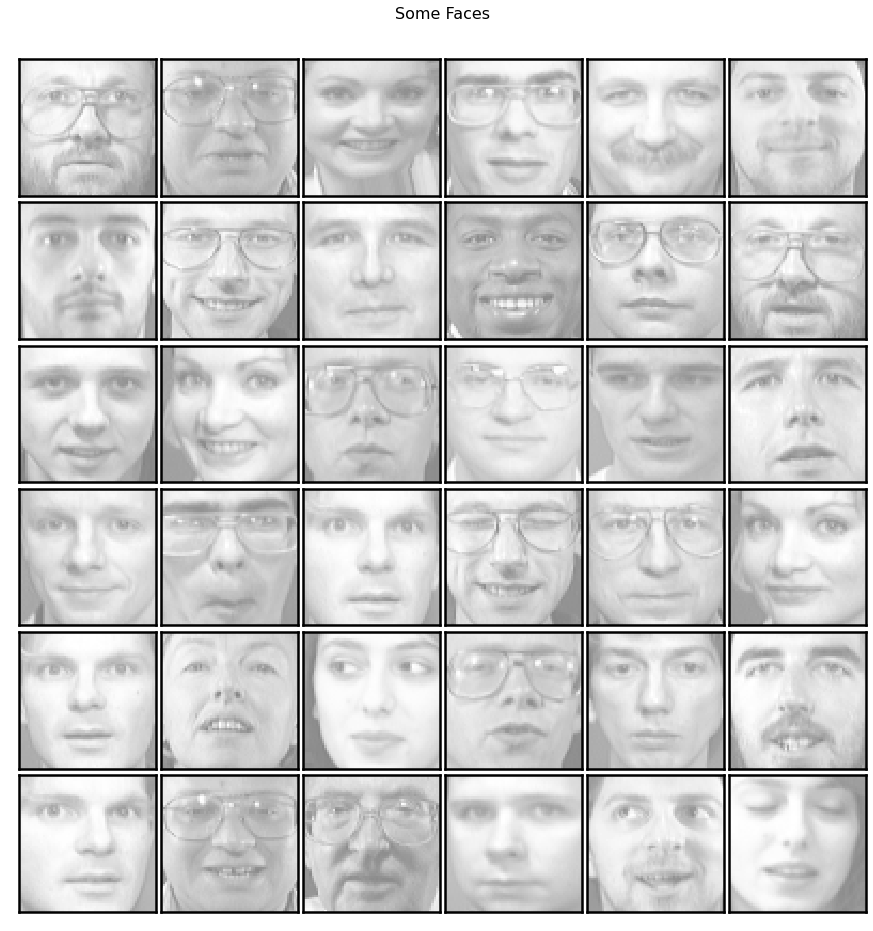

In [31]:


def plot_gallery(images, image_shape = (64, 64), nrow =6 , ncol =6, title='', cmap=plt.cm.gray):

    temp = faces.T  # n = 400 flattened images of p = 4096 = 64 x 64
    image_shape = (64, 64)
    n_samples, n_features = temp.shape

    # global centering
    faces_centered = temp - temp.mean(axis=0)

    # local centering
    faces_centered -= faces_centered.mean(axis=1).reshape(n_samples, -1)

    # fit the nb of images into a square
    n_images = len(images)
    nrows = nrow
    ncols = ncol
    
    # instantiate figure
    fig, axes = plt.subplots(nrows, ncols, figsize=(2. * ncols, 2.26 * nrows))
    fig.suptitle(title, size=16)
    
    axes_for_display = axes.flatten()[:n_images]
    axes_to_blank = axes.flatten()[n_images:]
    
    for idx, comp in enumerate(images):
        ax = axes_for_display[idx]
        vmax = max(comp.max(), -comp.min())
        ax.imshow(comp.reshape(image_shape), cmap=cmap,
                   interpolation='nearest',
                   vmin=-vmax, vmax=vmax)
        ax.set(xticks=(),
               yticks=())
        
    for ax in axes_to_blank:
        ax.axis('off')

    fig.tight_layout()
    fig.subplots_adjust(0.01, 0.05, 0.99, 0.93, 0.04, 0.)  # insert space below the suptitle
    

plot_gallery(title="Some Faces", 
             images=faces.T[:36], 
             nrow=6,ncol=6)


### Analysis of the number of components on the reconstruction

#### Reconstruction with Frobenius distance

100%|██████████| 200/200 [00:10<00:00, 19.31it/s]


(5, 400)
(4096, 5)


100%|██████████| 200/200 [00:11<00:00, 16.74it/s]


(10, 400)
(4096, 10)


100%|██████████| 200/200 [00:11<00:00, 16.72it/s]


(15, 400)
(4096, 15)


100%|██████████| 200/200 [00:11<00:00, 17.70it/s]


(20, 400)
(4096, 20)


100%|██████████| 200/200 [00:13<00:00, 14.95it/s]


(25, 400)
(4096, 25)


100%|██████████| 200/200 [00:08<00:00, 23.46it/s]


(30, 400)
(4096, 30)


100%|██████████| 200/200 [00:10<00:00, 18.20it/s]


(35, 400)
(4096, 35)


100%|██████████| 200/200 [00:11<00:00, 18.00it/s]


(40, 400)
(4096, 40)


100%|██████████| 200/200 [00:11<00:00, 17.41it/s]


(45, 400)
(4096, 45)


100%|██████████| 200/200 [00:09<00:00, 20.07it/s]


(50, 400)
(4096, 50)


100%|██████████| 200/200 [00:09<00:00, 21.36it/s]


(55, 400)
(4096, 55)


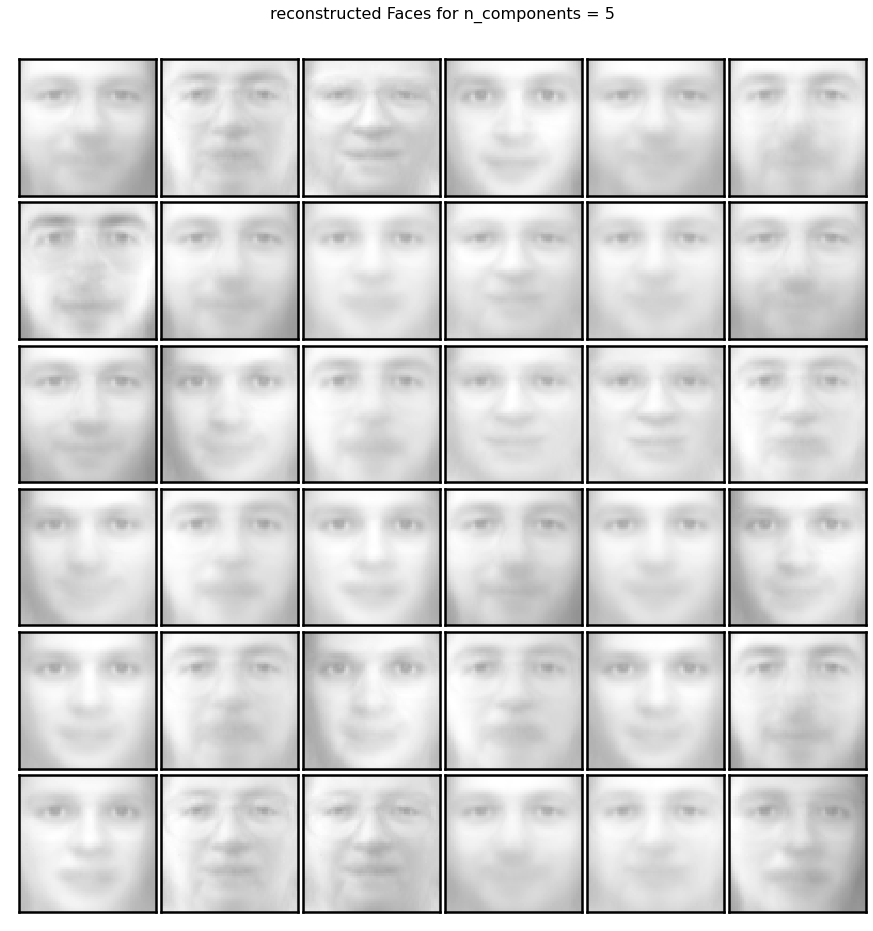

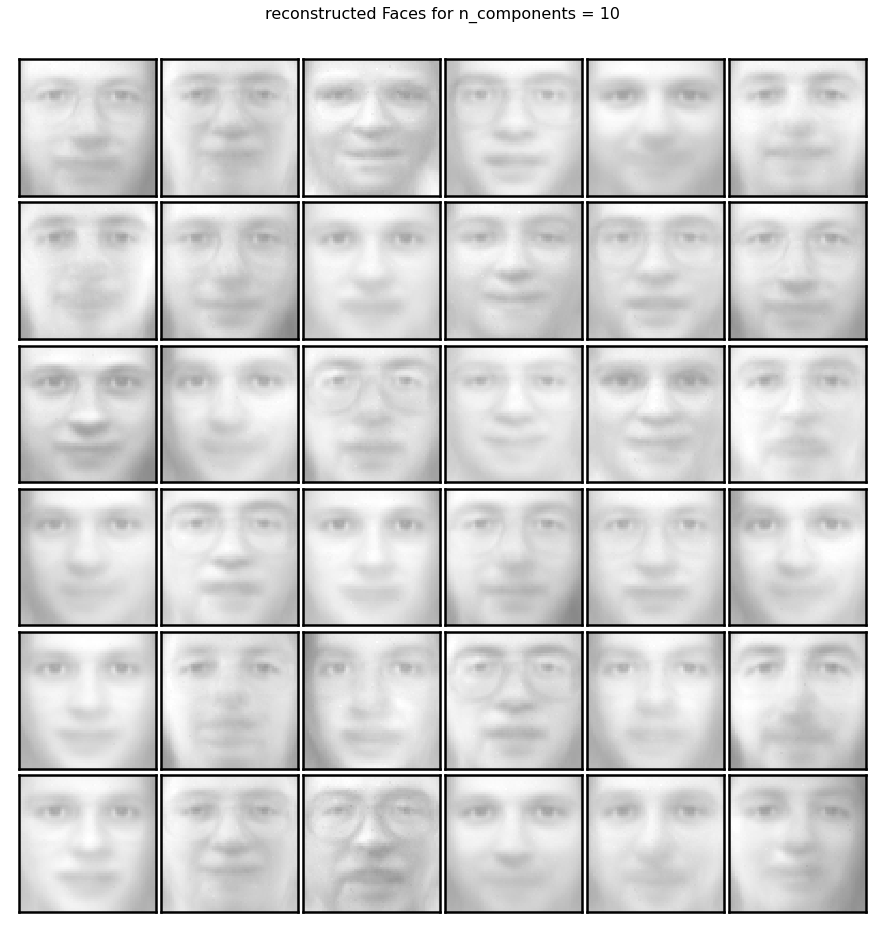

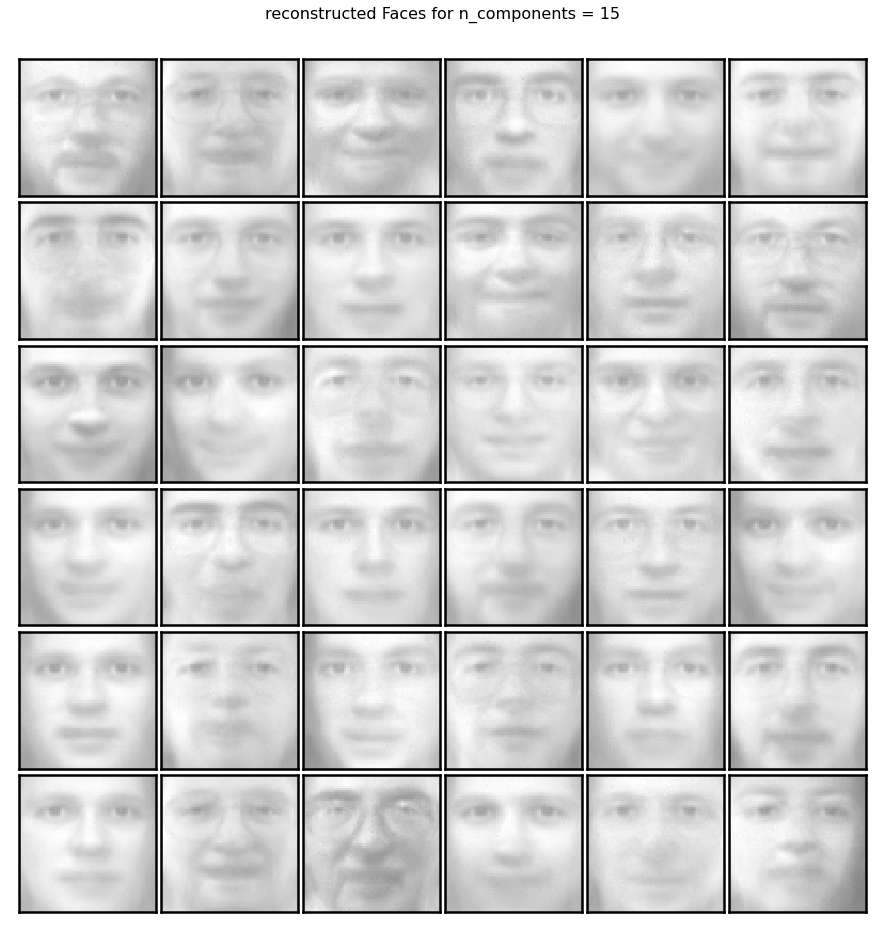

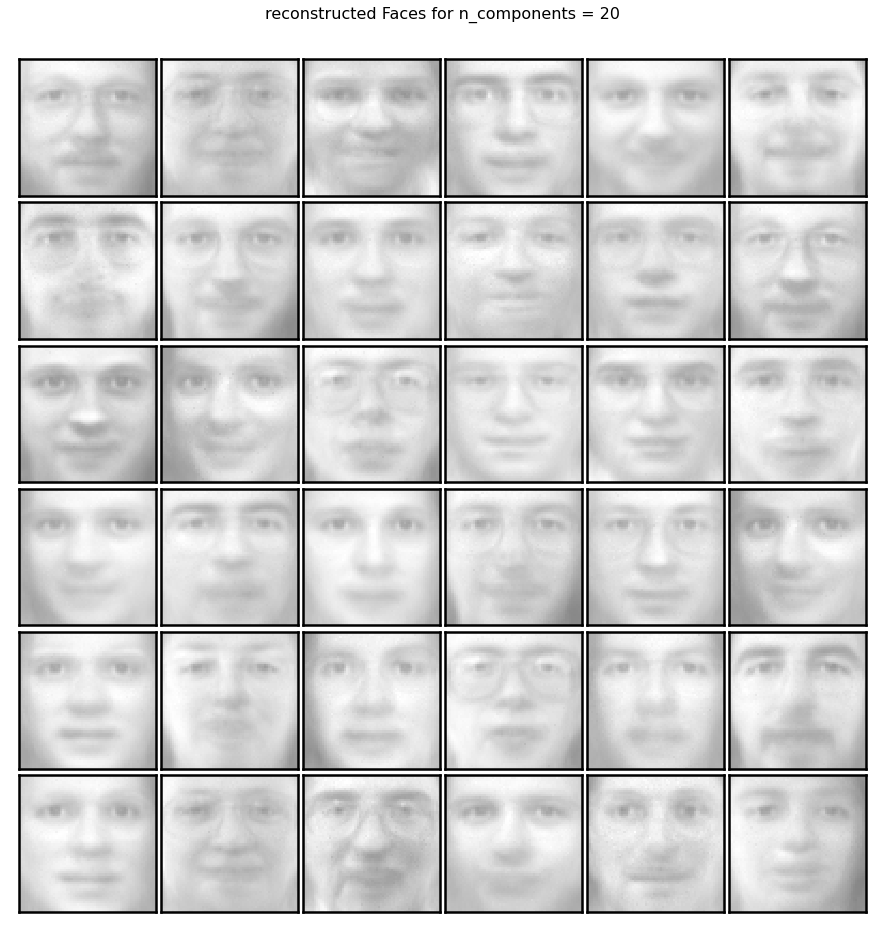

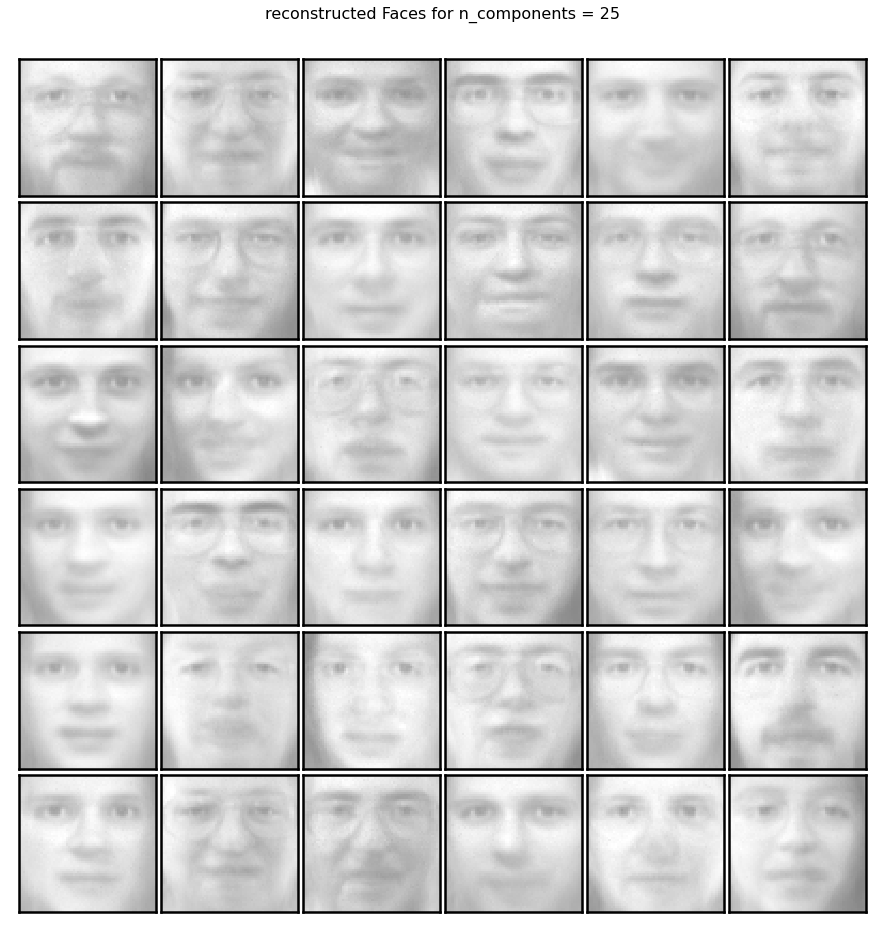

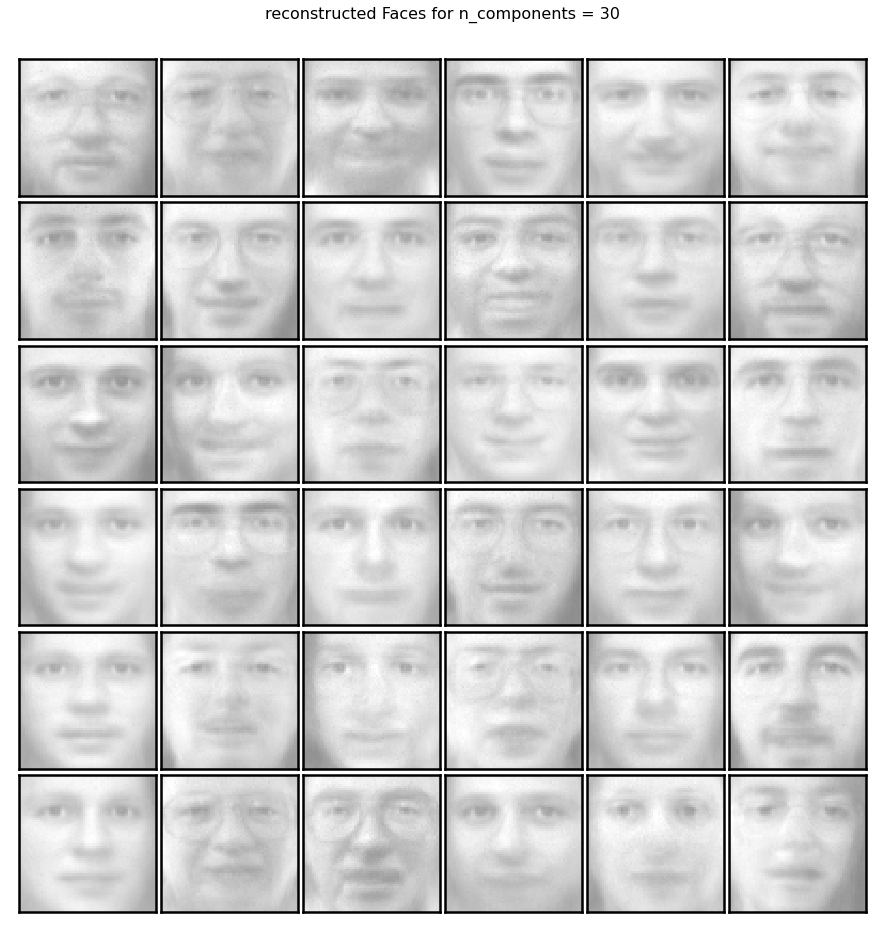

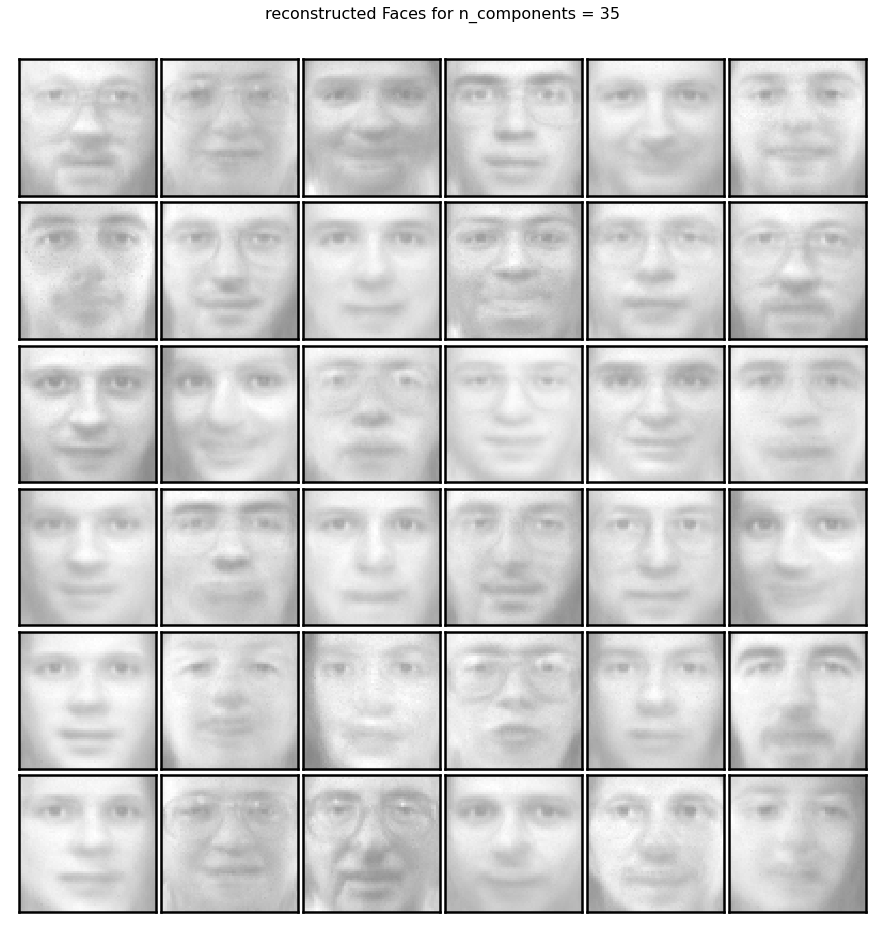

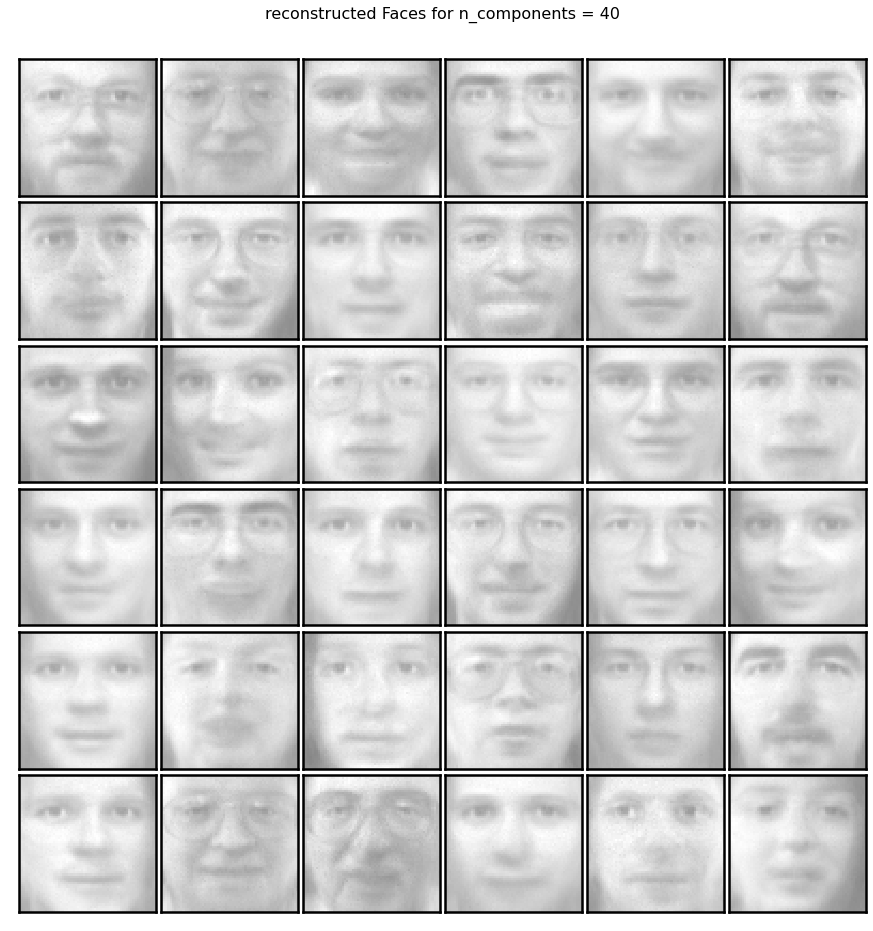

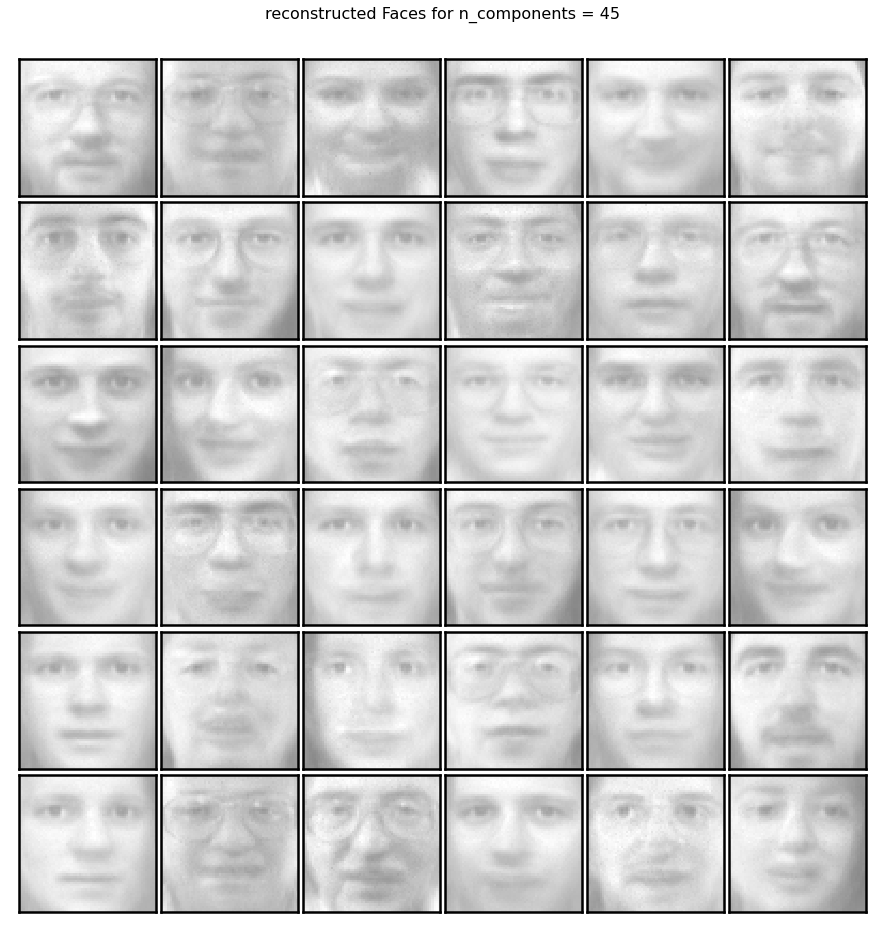

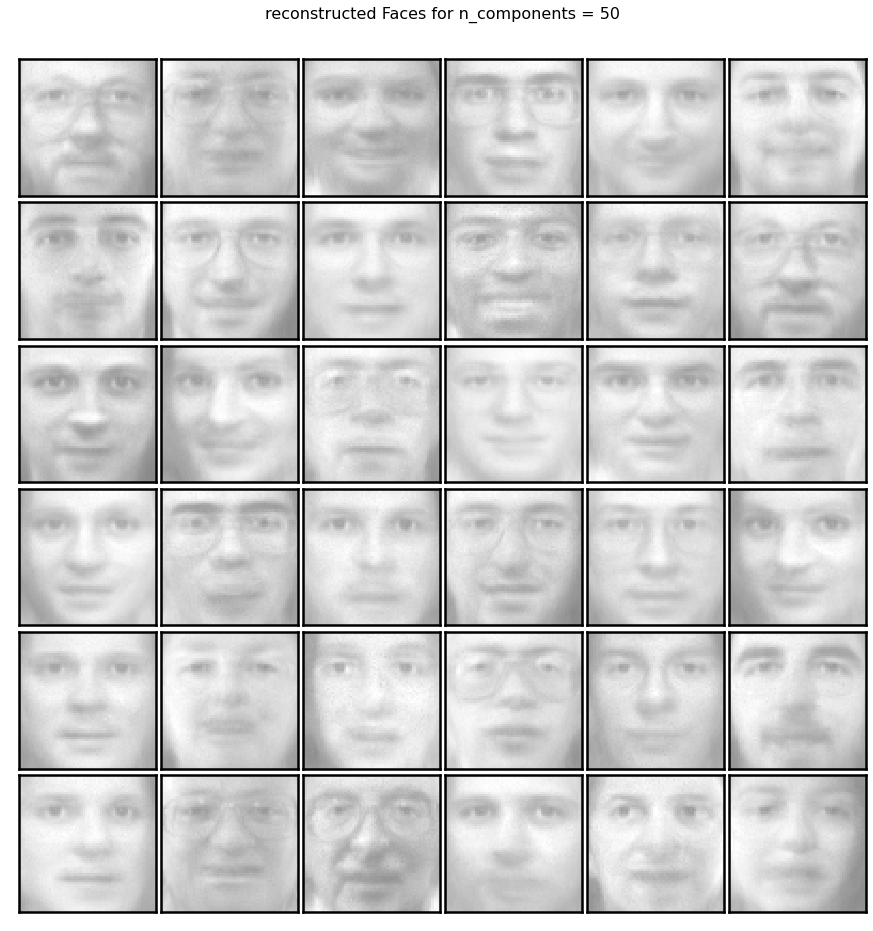

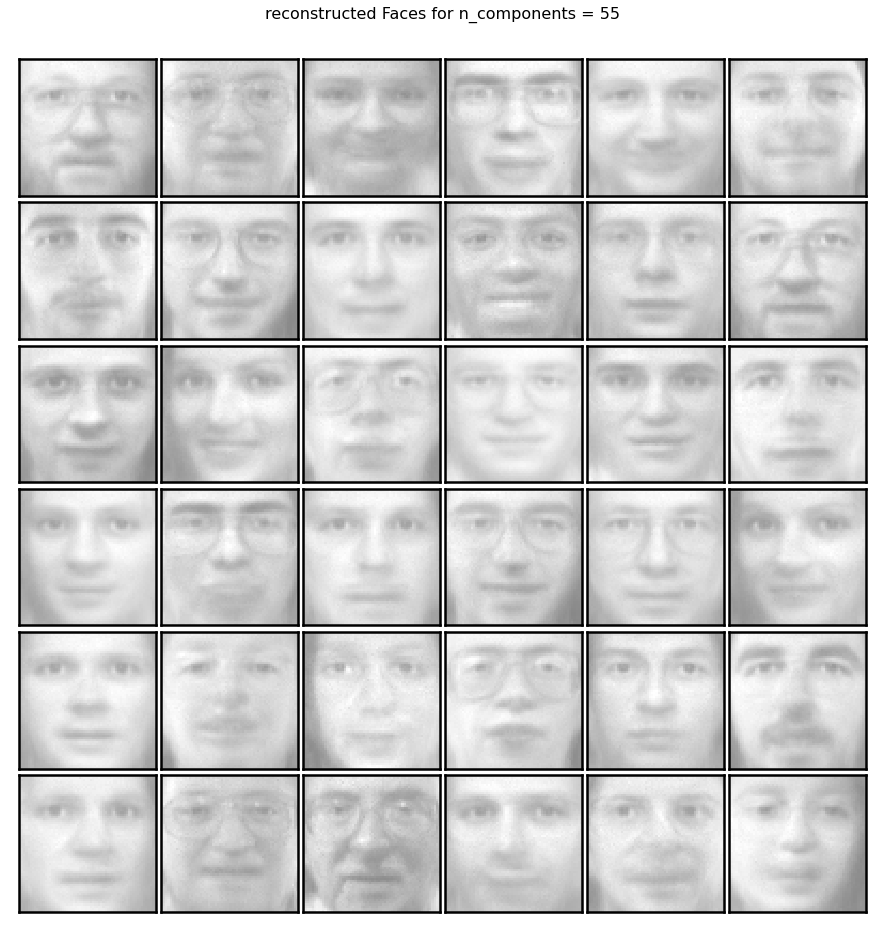

In [33]:
#TODO : plot reconstructed faces for different number of components with Frobenius distance
# first let's train different models with different number of componenets 
components = np.arange(5,60,5)
models = []
for nb_comp in components:
    model = MYNMF(n_components= nb_comp)
    embedding = model.fit_transform(faces, nu = 0, mu = 0.04, lambd= 0.3)
    print(embedding.shape)
    reconstructed_faces = model.components_@embedding
    print(model.components_.shape)
    plot_gallery(title=f"reconstructed Faces for n_components = {nb_comp}", 
             images=reconstructed_faces.T[:36], 
             nrow=6,ncol=6)

#### Reconstruction with Kullback-Leibler divergence

100%|██████████| 200/200 [00:38<00:00,  5.23it/s]


(5, 400)
(4096, 5)


100%|██████████| 200/200 [00:38<00:00,  5.21it/s]


(10, 400)
(4096, 10)


100%|██████████| 200/200 [00:29<00:00,  6.77it/s]


(15, 400)
(4096, 15)


100%|██████████| 200/200 [00:27<00:00,  7.30it/s]


(20, 400)
(4096, 20)


100%|██████████| 200/200 [00:27<00:00,  7.38it/s]


(25, 400)
(4096, 25)


100%|██████████| 200/200 [00:26<00:00,  7.54it/s]


(30, 400)
(4096, 30)


100%|██████████| 200/200 [00:29<00:00,  6.71it/s]


(35, 400)
(4096, 35)


100%|██████████| 200/200 [00:26<00:00,  7.41it/s]


(40, 400)
(4096, 40)


100%|██████████| 200/200 [00:28<00:00,  7.11it/s]


(45, 400)
(4096, 45)


100%|██████████| 200/200 [00:27<00:00,  7.16it/s]


(50, 400)
(4096, 50)


100%|██████████| 200/200 [00:28<00:00,  7.14it/s]


(55, 400)
(4096, 55)


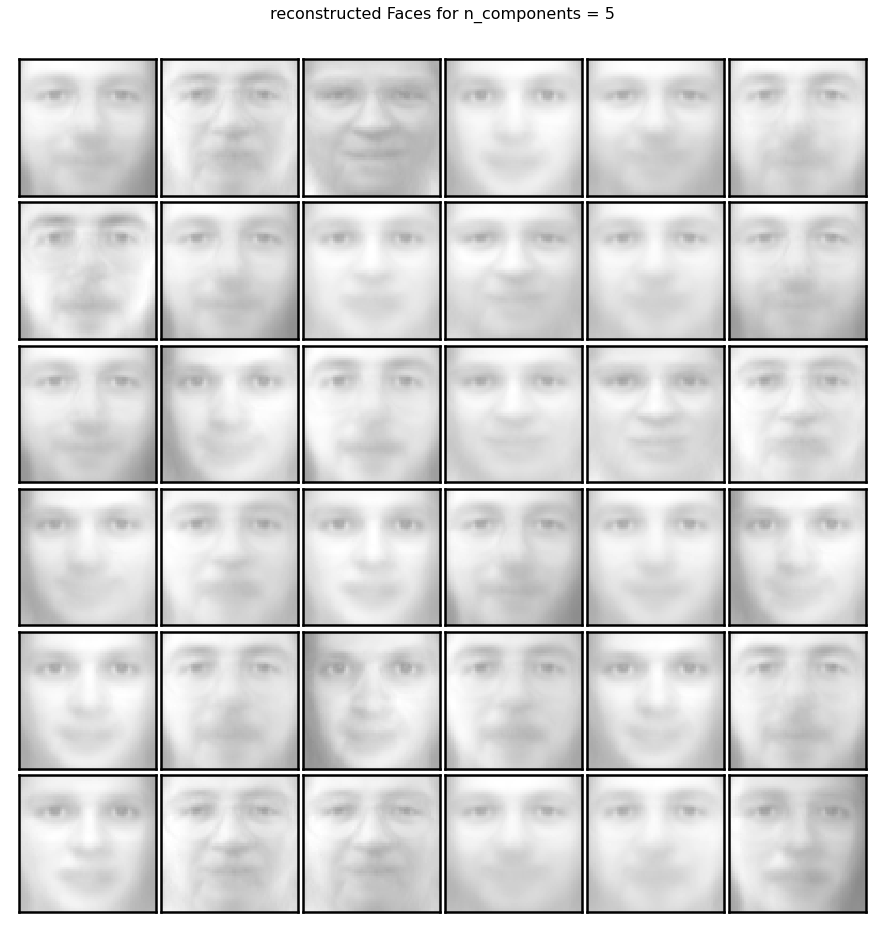

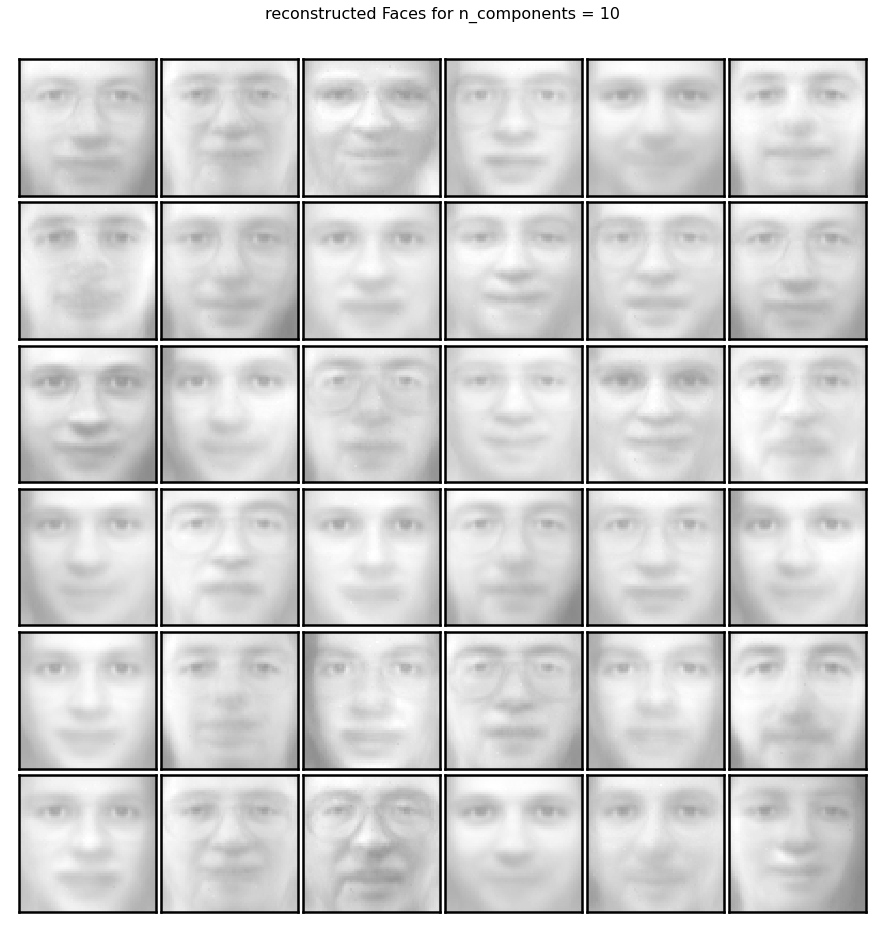

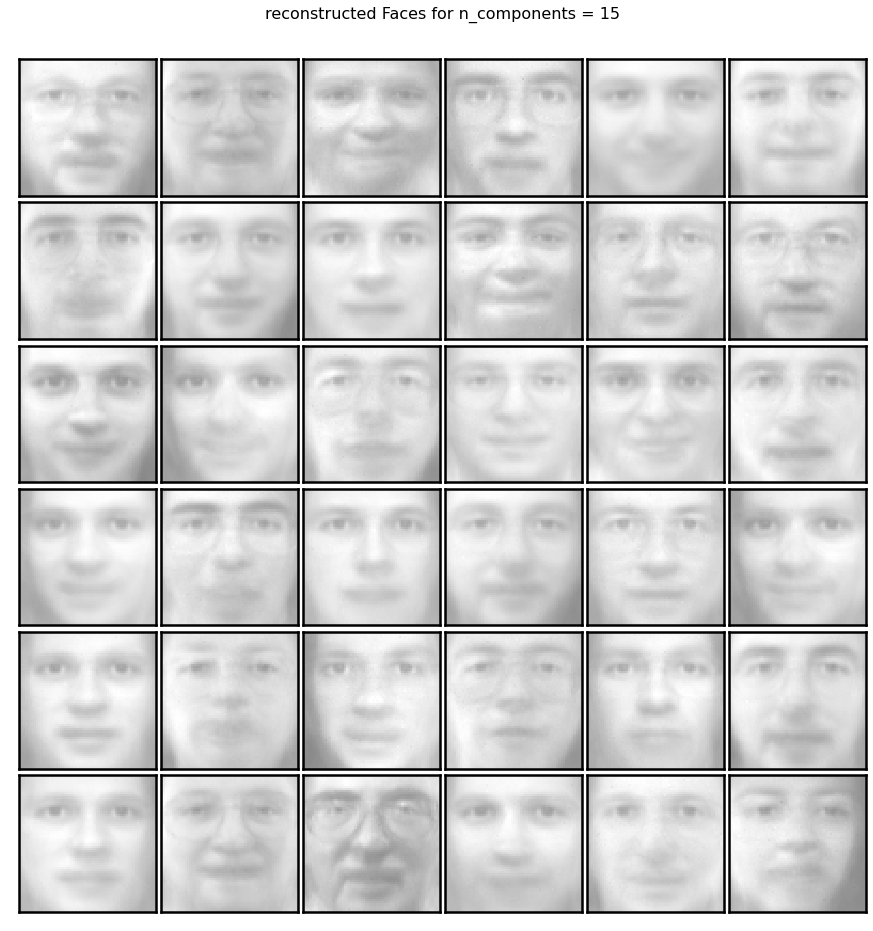

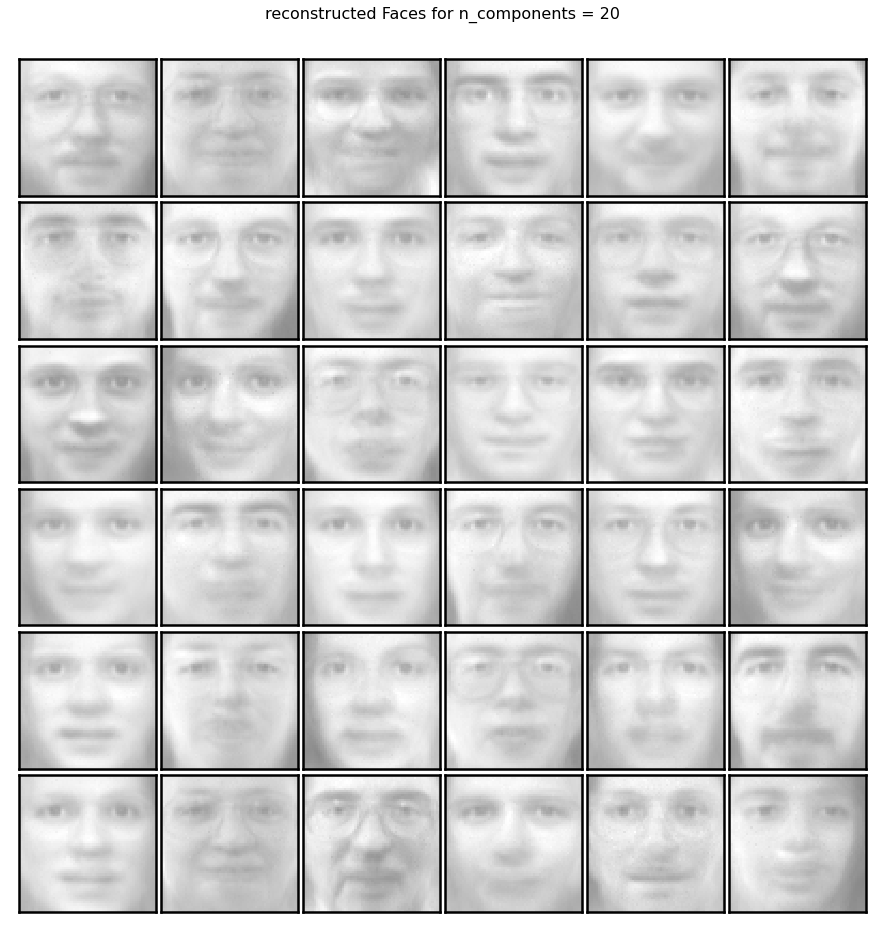

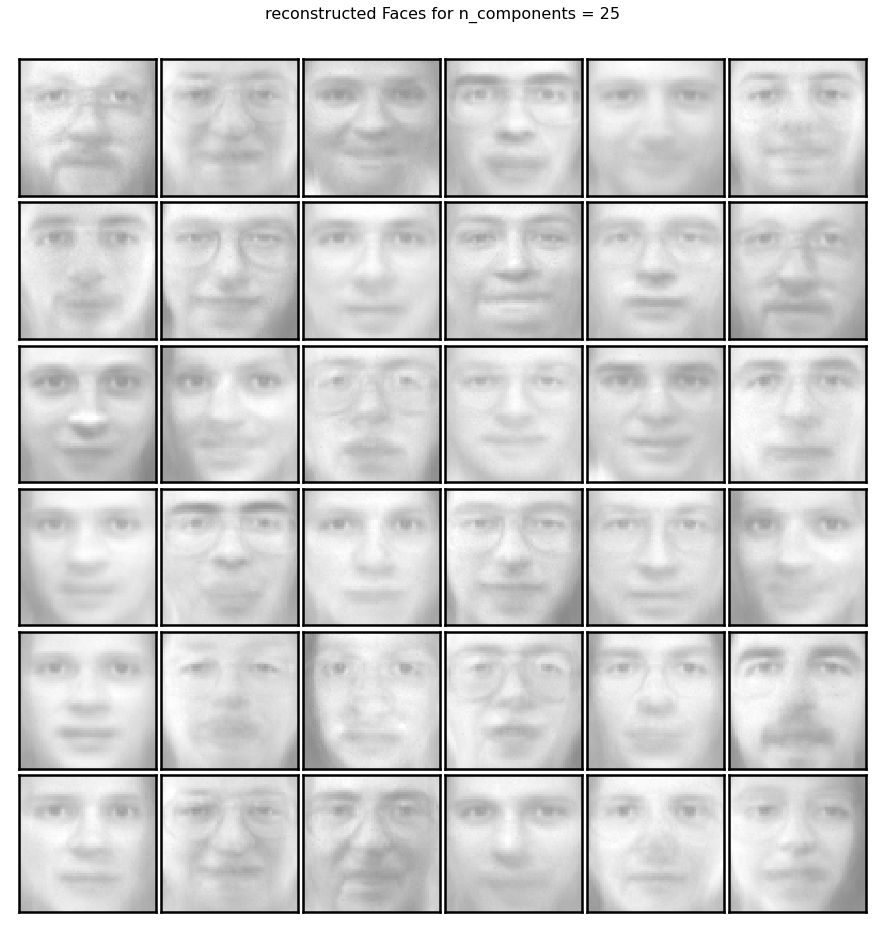

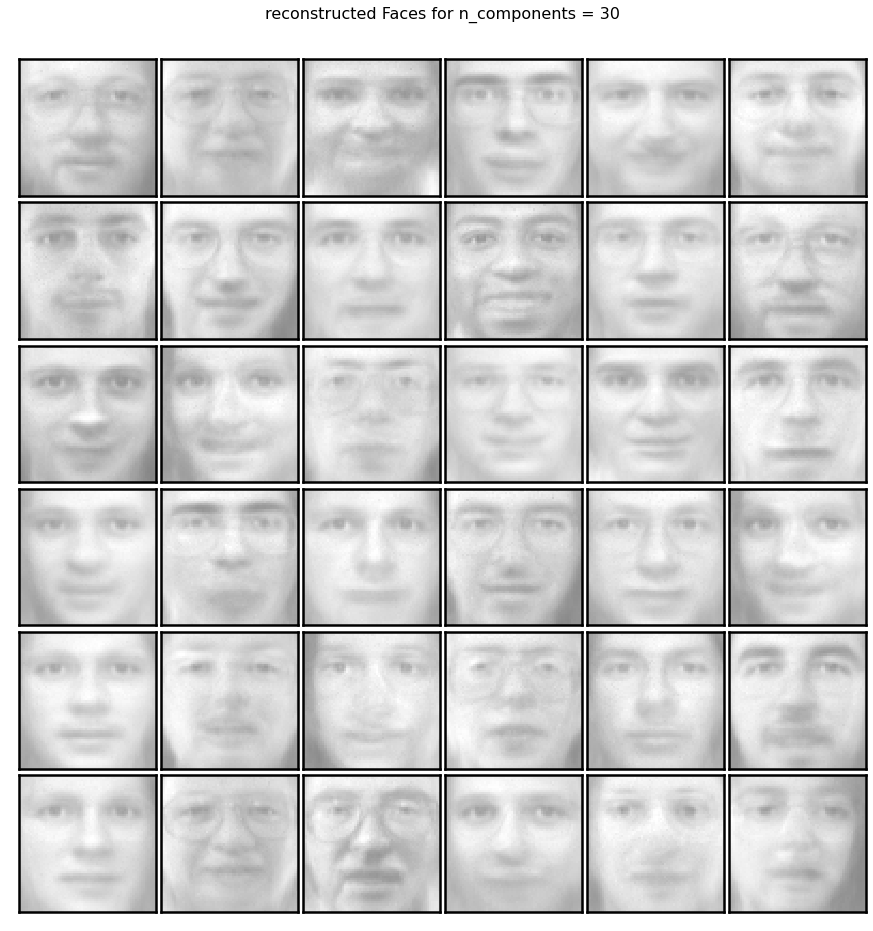

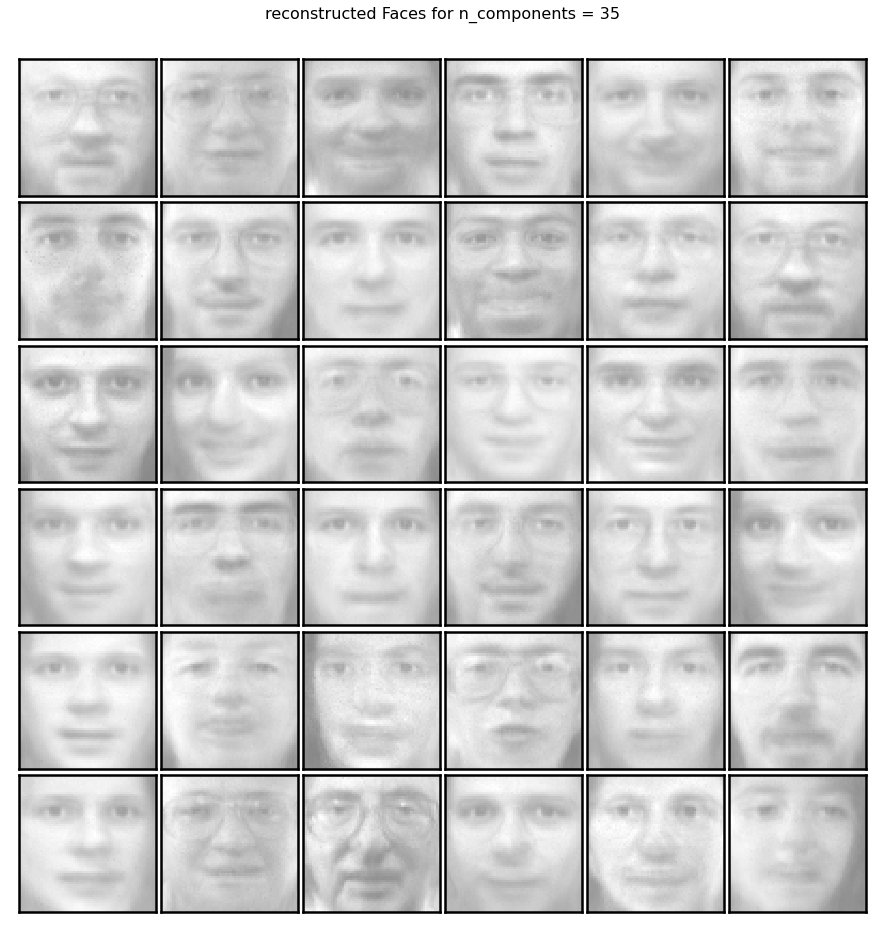

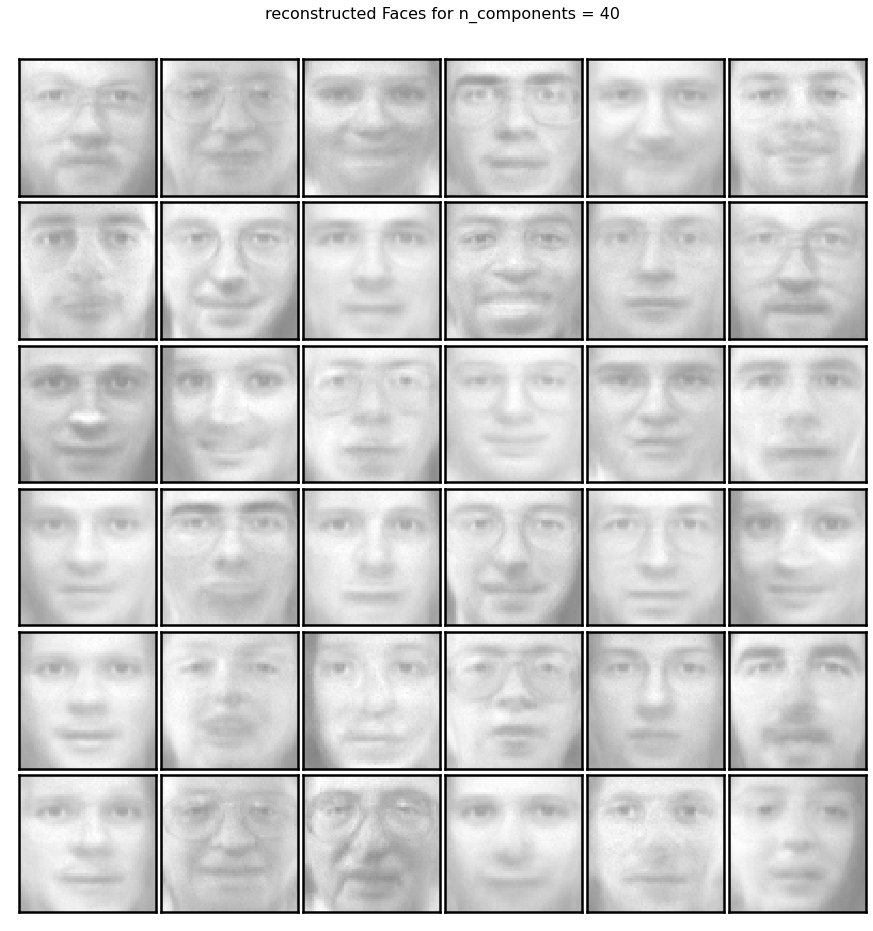

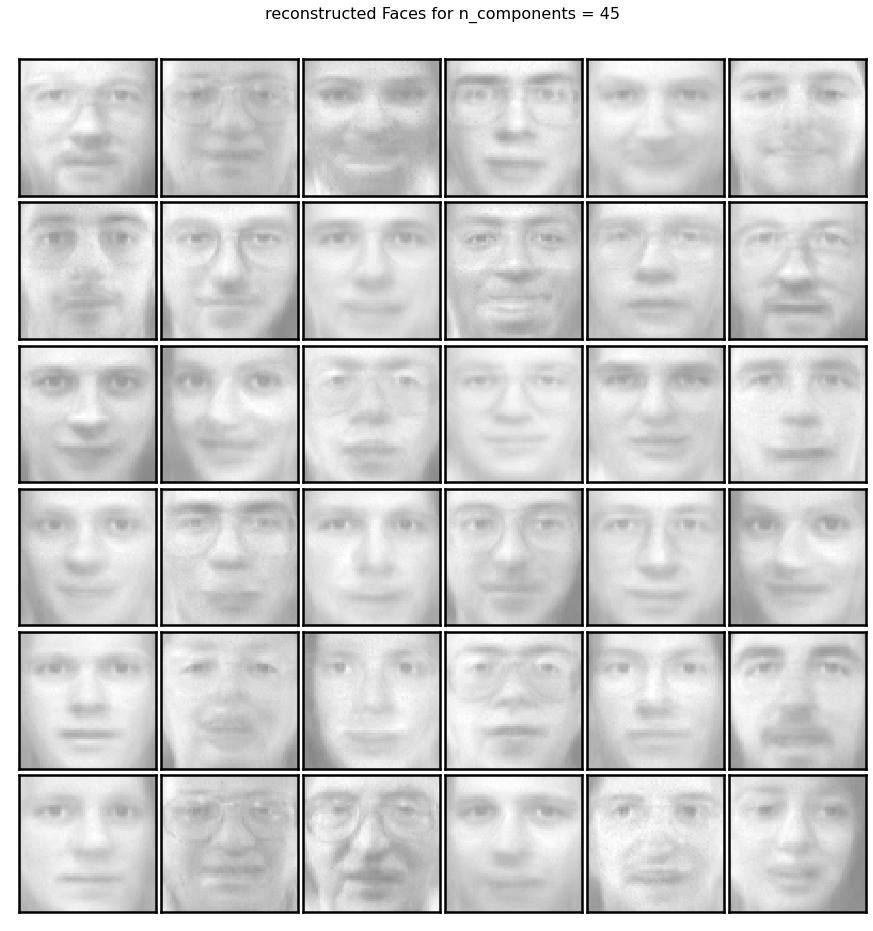

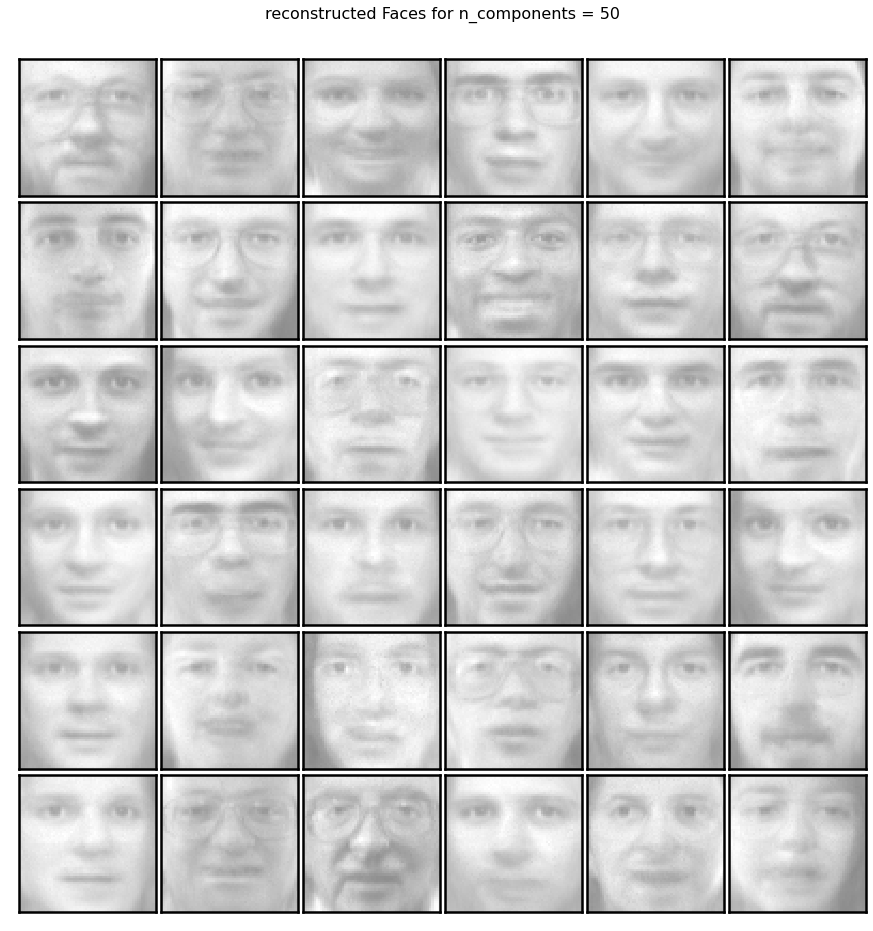

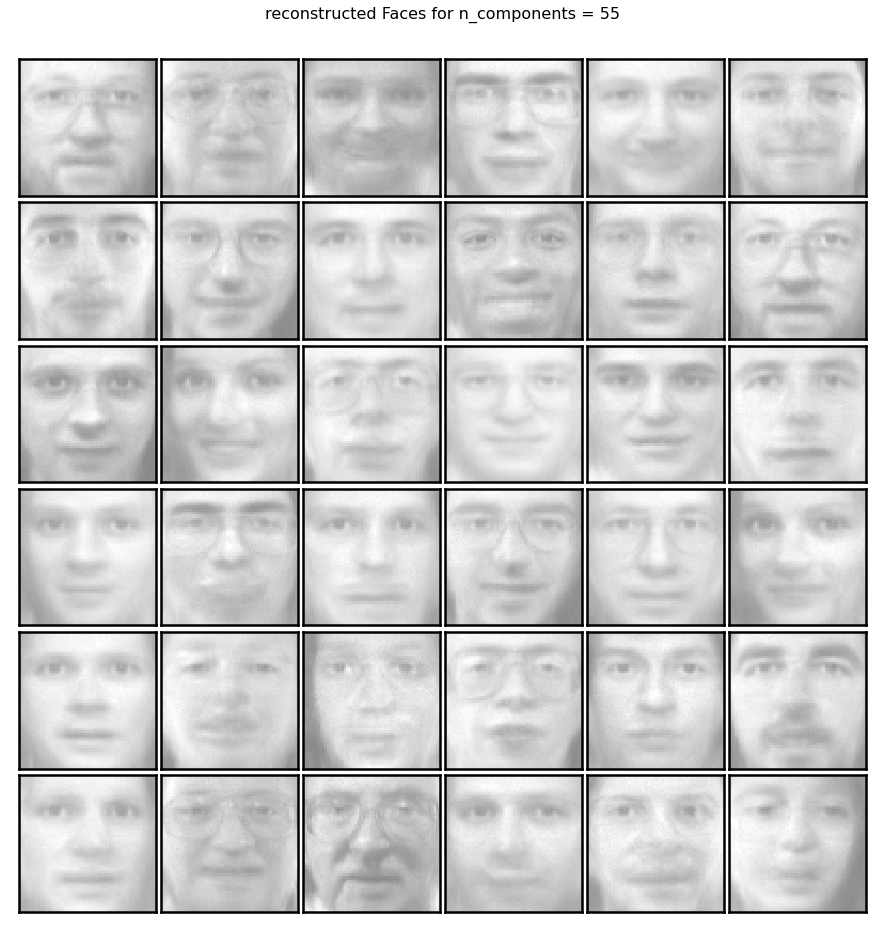

In [34]:
#TODO : plot reconstructed faces for different number of components with KL divergence
# Let's do the same thing with KL divergence 
# filter warnings
import warnings
warnings.filterwarnings('ignore')
components = np.arange(5,60,5)
models = []
for nb_comp in components:
    model = MYNMF(n_components= nb_comp, loss= 'KL')
    embedding = model.fit_transform(faces)
    print(embedding.shape)
    reconstructed_faces = model.components_@embedding
    print(model.components_.shape)
    plot_gallery(title=f"reconstructed Faces for n_components = {nb_comp}", 
             images=reconstructed_faces.T[:36], 
             nrow=6,ncol=6)

#### Comparison of the elements of the dictionary between the two distances

In [36]:
#TODO : plot the atoms of the dictionary for various number of components
# for frobinius distance
components = np.arange(5,60,5)
atoms = []
for nb_comp in components:
    model = MYNMF(n_components= nb_comp)
    embedding = model.fit_transform(faces, nu = 0, mu = 0.04, lambd= 0.3)
    atoms.append(model.components_)

100%|██████████| 200/200 [00:14<00:00, 13.84it/s]


### Study of the clustering for the Frobenius distance with 30 components

Now, we are going to clusterise the images in r different classes. First, we start by normalizing the norm of the dictionary elements, so that the euclidian norm = 1, and we multiply the associated row in the S matrix to preserve the factorization DS = X. Then, we find the highest coefficient for each image, and we use the index of the maximum as clustering label.

In [39]:
#TODO : Study the clustering
model = MYNMF(n_components= 30)
embedding = model.fit_transform(faces, nu = 0, mu = 0.04, lambd= 0.3)
components =model.components_
norms = np.linalg.norm(components, axis = 0)
components /= norms 
embedding *= norms[:,None]

100%|██████████| 200/200 [00:13<00:00, 14.40it/s]


In [40]:
embedding.shape

(30, 400)

In [41]:
predicted_clusters = np.argmax(embedding,axis = 0)
print(predicted_clusters)

[18  3 19 26  9  3  0  3 19 28 26 15  5 25 13 26 26 19  0 26 16  3 16 22
 24 29 19 13 26  3  4  3  3  0 19  1 12  4 22 22 29  9 13  1  9 26  9 21
 13 19  0 16 26  4  1  8  9 13 12  0 25 22  2  3 21  9 28 19  0  3  2  3
 21 21 29 13 12  3 12  9  3  3 26 29 26  0 19 24 27  9 12  4 19 24  4 20
 20  4  3 12  3  0  3  1  1 19  9  5  4 24  4  4  9  4 12 28 20  2 19 19
  4  0 23 19  9 19  4 21  0 19  0 22 29  9 28  3  8 21  9  8  2  3 21  5
  8 18 24  9 19  5  3  9  1  0  6 15  3  0 26 28  1 15  4 24 12  4 29  4
  9  3  2  1 20 25 29 16  3 26  9 22  4 20 18 20  4  6  4 21 24  3 26  9
  0 21 23  6 29 28  9  4 20 19  6  3  3 26 19  0 19 24 10 26  3  0 20 19
  6  5 19 22 12  5 12 13  1  1  1 24  4 13 12 13 12  6  0  2 29  2  5  3
  4  4  4 14  4 24  4  4 19  1  8  3 29 23  9 19 13 18 19  8  9  9  8  0
  9  2  3 13 25 21  3  9 19 24 19  9 15 13  9  0  8 16 19 24  9  3 13 26
 23 20 26  0  9 19  3 15 14 21 12 24 27  3  0 20  4  3  4 21  4 19 19  0
  9  5 26 22  4 19 26 21 18  0  0  3 29  4  5 20 19

In [44]:
from collections import Counter
Counter(predicted_clusters)

Counter({18: 5,
         3: 44,
         19: 36,
         26: 22,
         9: 37,
         0: 28,
         28: 7,
         15: 5,
         5: 11,
         25: 5,
         13: 15,
         16: 5,
         22: 9,
         24: 15,
         29: 12,
         4: 39,
         1: 12,
         12: 18,
         21: 17,
         8: 10,
         2: 11,
         27: 2,
         20: 15,
         23: 4,
         6: 8,
         10: 6,
         14: 2})

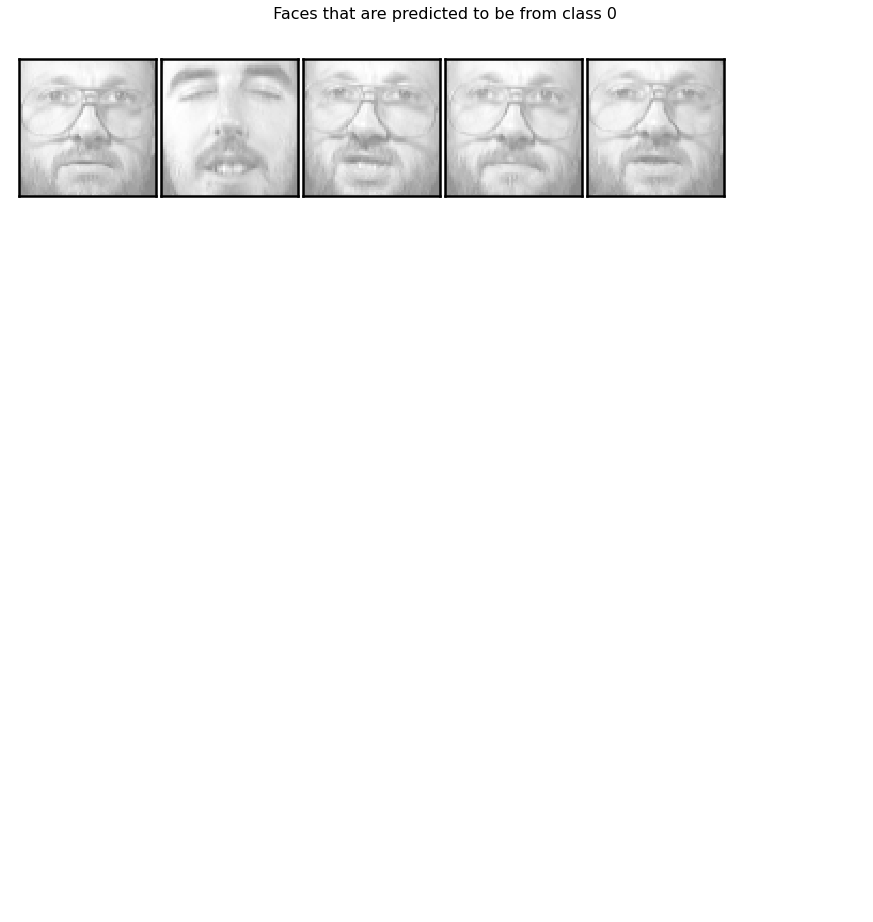

In [45]:
# Now let's print some faces from the same class, say class 18:

plot_gallery(title=f" Faces that are predicted to be from class 18", 
             images=faces.T[np.where(predicted_clusters == 18)], 
             nrow=6,ncol=6)

#### We can see that our algorithm can identify images for same person

### Second application 

Import the 20newsgroups dataset (from sklearn.datasets import fetch_20newsgroups_vectorized) that contains a collection of ~18,000 newsgroup documents from 20 different newsgroups.

Model the topics present in a subsample with *scikit-learn's* NMF. Print the most common words of each topic. 

Discuss.

In [ ]:
from sklearn.datasets import fetch_20newsgroups
help(data)

Help on function fetch_20newsgroups_vectorized in module sklearn.datasets._twenty_newsgroups:

fetch_20newsgroups_vectorized(*, subset='train', remove=(), data_home=None, download_if_missing=True, return_X_y=False, normalize=True, as_frame=False)
    Load and vectorize the 20 newsgroups dataset (classification).
    
    Download it if necessary.
    
    This is a convenience function; the transformation is done using the
    default settings for
    :class:`~sklearn.feature_extraction.text.CountVectorizer`. For more
    advanced usage (stopword filtering, n-gram extraction, etc.), combine
    fetch_20newsgroups with a custom
    :class:`~sklearn.feature_extraction.text.CountVectorizer`,
    :class:`~sklearn.feature_extraction.text.HashingVectorizer`,
    :class:`~sklearn.feature_extraction.text.TfidfTransformer` or
    :class:`~sklearn.feature_extraction.text.TfidfVectorizer`.
    
    The resulting counts are normalized using
    :func:`sklearn.preprocessing.normalize` unless normal

In [ ]:
from sklearn.datasets import fetch_20newsgroups_vectorized as data
from sklearn.decomposition import NMF

In [ ]:
#let's visualize what's data looks like
dataset = data(as_frame= True).data

In [ ]:
# Since we know in advance that there is 20 classes let's use it as the number of componenets :)
# In scikit learn the model  NMF takes as input of dimesnions:n_samples, n_features 
model = NMF(n_components= 20)
embeddings = model.fit_transform(dataset)

In [ ]:

# To get the most commun words for each topic , One may model a topic as "a sum of weighted words" , so we need the words/features names and then select the one will highest associated weights 
words = data().feature_names
print(words) 

['00' '000' '0000' ... 'íålittin' 'ñaustin' 'ýé']


In [ ]:
# Now let's print the 5 most commun words for each topic 
# to get the D matrix we should transpose the matrix 

topic_matrix = model.components_.T
for topic in range(topic_matrix.shape[1]):
    # we need the index of most important words, so we wil use argsort function
    most_important_words = words[list(reversed(topic_matrix[:, topic].argsort()))[:5]]
    print(f'the most 5 important words for topic {topic} are : {most_important_words}')

the most 5 important words for topic 0 are : ['the' 'from' 'at' 'by' 'with']
the most 5 important words for topic 1 are : ['is' 'not' 'there' 'what' 'as']
the most 5 important words for topic 2 are : ['edu' 'university' 'organization' 'subject' 'article']
the most 5 important words for topic 3 are : ['of' 'by' 'one' 'as' 'university']
the most 5 important words for topic 4 are : ['to' 'do' 'get' 'want' 'how']
the most 5 important words for topic 5 are : ['and' 'with' 'all' 'from' 'other']
the most 5 important words for topic 6 are : ['in' 'article' 'writes' 'an' 're']
the most 5 important words for topic 7 are : ['com' 're' 'writes' 'organization' 'subject']
the most 5 important words for topic 8 are : ['you' 'your' 'if' 're' 'do']
the most 5 important words for topic 9 are : ['it' 'but' 'just' 'was' 'like']
the most 5 important words for topic 10 are : ['for' 'sale' 'looking' 'new' 'at']
the most 5 important words for topic 11 are : ['that' 'not' 'we' 'the' 'for']
the most 5 important

**Conclusion:** Even is we got stopping words as the most important words in the text, this is coherent because any text contain a lot of stopping words. A safe approach is to not consider stopping words while vectorizing the original text 